In [ ]:

# Required Libraries
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


def train_and_evaluate(fake_data_path, real_data_path, output_dir):

  # Step 1: Load and Prepare Data
  # put location of dataset here
  data1 = pd.read_csv(fake_data_path)
  data2 = pd.read_csv(real_data_path)

  data = pd.concat([data1, data2], ignore_index=True)
  best_auc = 0
  best_model = None
  best_model_name = ""
  # Encode Labels: FAKE -> 0, REAL -> 1
  label_encoder = LabelEncoder()
  data['type'] = label_encoder.fit_transform(data['type'])
  columns_to_drop = ['file_name', 'interval_start', 'interval_end']  # Drop metadata


  # Separate Features and Labels
  X = data.drop(columns=columns_to_drop + ['type'])
  y = data['type']

  # Normalize Features
  # Split Data: Train/Test (80-20 split)
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, stratify=y
  )

  # Step 3: Normalize Features (Fit on Training Data Only, Then Transform Test Data)
  scaler = StandardScaler()
  X_train_scaled = X_train  # Fit and transform on training data
  X_test_scaled = X_test  # Only transform on test data

  # Step 4: Define Models
  models = {
      'SVC': SVC(probability=True, random_state=42),  # Enable probability for ROC/PR curves
      'Naive Bayes': GaussianNB(),
      'KNN': KNeighborsClassifier(n_neighbors=5),
      'Random Forest': RandomForestClassifier(random_state=42),
      'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
  }

  # Step 5: Train Models
  for name, model in models.items():
      model.fit(X_train_scaled, y_train)

  # Step 6: Evaluate Model Performance
  def plot_confusion_matrix(cm, title):
      plt.figure(figsize=(5, 4))
      sns.heatmap(
          cm,
          annot=True,
          fmt='d',
          cmap='Blues',
          xticklabels=['FAKE', 'REAL'],
          yticklabels=['FAKE', 'REAL'],
      )
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.title(title)
      plt.show()

  print("\n=== Model Performance ===")
  for name, model in models.items():
      y_pred = model.predict(X_test_scaled)
      cm = confusion_matrix(y_test, y_pred)

      # Print Metrics
      print(f"\n{name} Metrics:")
      print(classification_report(y_test, y_pred, target_names=['FAKE', 'REAL']))

      # Plot Confusion Matrix
      plot_confusion_matrix(cm, title=f'{name} Confusion Matrix')

  # Step 7: Precision-Recall and ROC Curves
  print("\n=== Precision-Recall and ROC Curves ===")
  for name, model in models.items():
      if hasattr(model, "predict_proba"):
          y_proba = model.predict_proba(X_test_scaled)[:, 1]
      else:
          y_proba = model.decision_function(X_test_scaled)

      # Plot Precision-Recall Curve
      PrecisionRecallDisplay.from_predictions(y_test, y_proba)
      plt.title(f'{name} Precision-Recall Curve')
      plt.show()

      # Plot ROC Curve
      RocCurveDisplay.from_predictions(y_test, y_proba)
      plt.title(f'{name} ROC Curve')
      plt.show()

      # Print AUC-ROC
      auc = roc_auc_score(y_test, y_proba)
      print(f"{name} AUC-ROC: {auc:.4f}")

      if auc > best_auc:
          best_auc = auc
          best_model = model
          best_model_name = name

  # Step 8: Cross-Validation
  print("\n=== Cross-Validation Scores ===")
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  for name, model in models.items():
      scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')  # Only use training data for CV
      print(f"{name} Cross-Validation Accuracy: Mean = {scores.mean():.4f}, Std = {scores.std():.4f}")

  # Step 9: Feature Importance
  print("\n=== Feature Importance ===")
  for name, model in models.items():
      print(f"\n{name} Feature Importance:")
      if hasattr(model, "feature_importances_"):  # For models like Random Forest
          feature_importances = model.feature_importances_
          importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
          importance_df = importance_df.sort_values(by='Importance', ascending=False)
      else:
          # Use permutation importance for models without intrinsic feature importance
          perm_importance = permutation_importance(model, X_test_scaled, y_test, scoring='accuracy', random_state=42)
          importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
          importance_df = importance_df.sort_values(by='Importance', ascending=False)

      # Print Top Features
      print(importance_df.head())

      # Plot Feature Importances
      plt.figure(figsize=(10, 6))
      sns.barplot(x='Importance', y='Feature', data=importance_df)
      plt.title(f'{name} Feature Importances')
      plt.xlabel('Importance')
      plt.ylabel('Feature')
      plt.show()

  # Step 10: Save the Best Model
  if best_model is not None:
      print(f"\nSaving the best model: {best_model_name} with AUC-ROC: {best_auc:.4f}")
      joblib.dump(best_model, f"{best_model_name}_best_model.joblib")
  else:
      print("No model performed well enough to be saved.")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:18:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Model Performance ===

SVC Metrics:
              precision    recall  f1-score   support

        FAKE       0.88      1.00      0.94      5243
        REAL       0.92      0.06      0.12       750

    accuracy                           0.88      5993
   macro avg       0.90      0.53      0.53      5993
weighted avg       0.89      0.88      0.83      5993



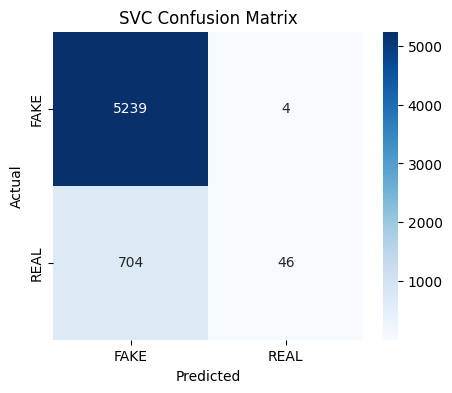


Naive Bayes Metrics:
              precision    recall  f1-score   support

        FAKE       0.92      0.91      0.92      5243
        REAL       0.42      0.45      0.43       750

    accuracy                           0.85      5993
   macro avg       0.67      0.68      0.67      5993
weighted avg       0.86      0.85      0.86      5993



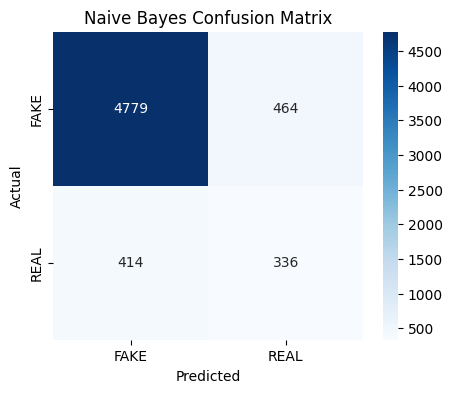


KNN Metrics:
              precision    recall  f1-score   support

        FAKE       0.91      0.98      0.94      5243
        REAL       0.67      0.33      0.45       750

    accuracy                           0.90      5993
   macro avg       0.79      0.66      0.70      5993
weighted avg       0.88      0.90      0.88      5993



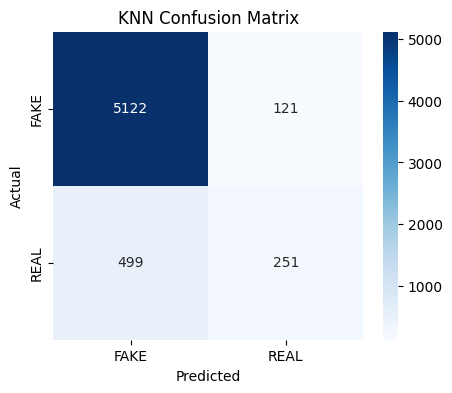


Random Forest Metrics:
              precision    recall  f1-score   support

        FAKE       0.97      1.00      0.98      5243
        REAL       0.98      0.80      0.88       750

    accuracy                           0.97      5993
   macro avg       0.98      0.90      0.93      5993
weighted avg       0.97      0.97      0.97      5993



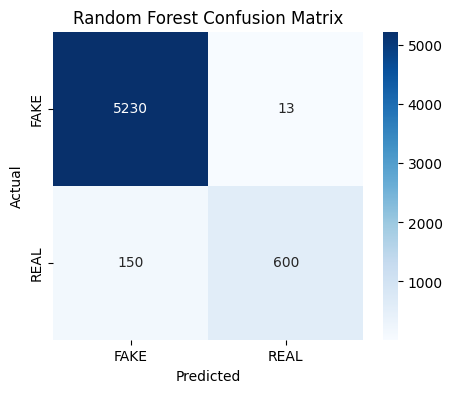


XGBoost Metrics:
              precision    recall  f1-score   support

        FAKE       0.99      1.00      0.99      5243
        REAL       0.97      0.91      0.94       750

    accuracy                           0.98      5993
   macro avg       0.98      0.95      0.96      5993
weighted avg       0.98      0.98      0.98      5993



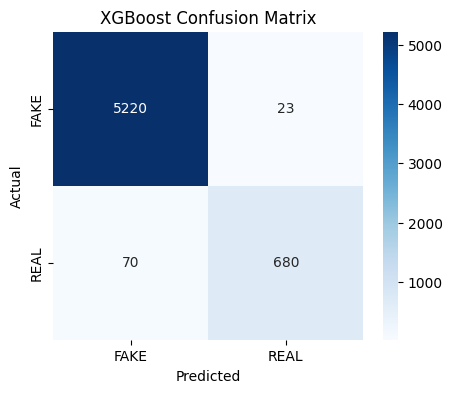


=== Precision-Recall and ROC Curves ===


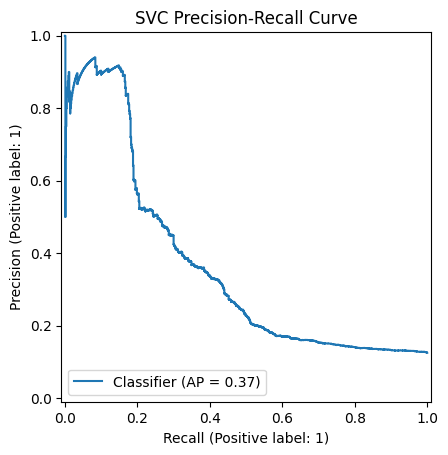

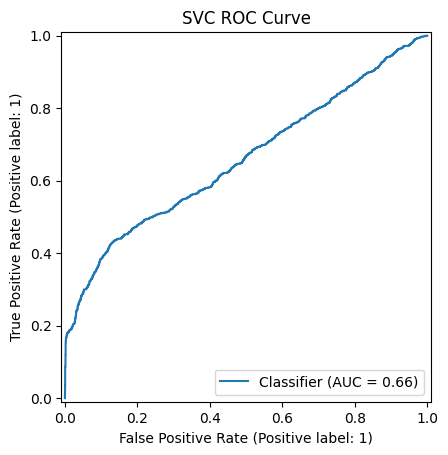

SVC AUC-ROC: 0.6586


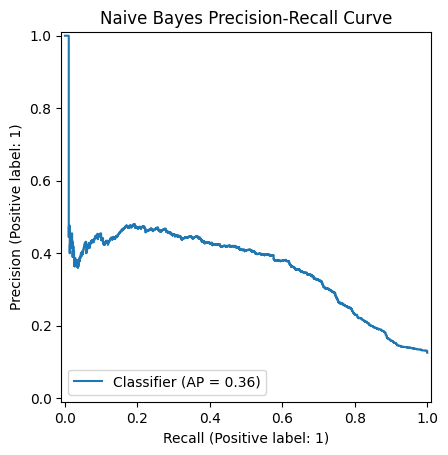

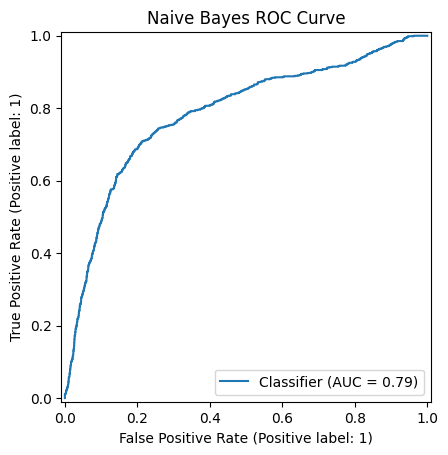

Naive Bayes AUC-ROC: 0.7858


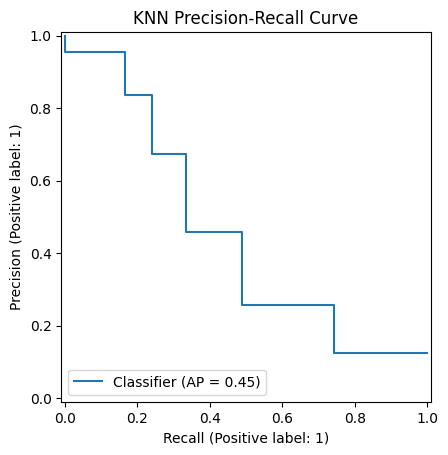

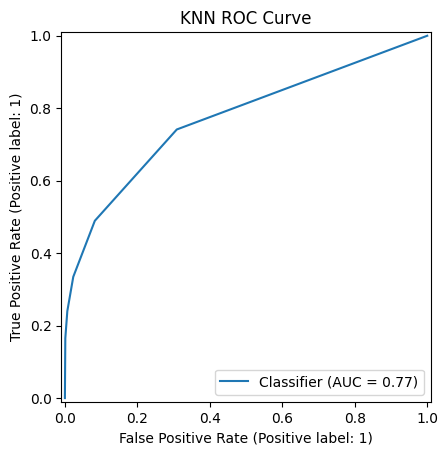

KNN AUC-ROC: 0.7714


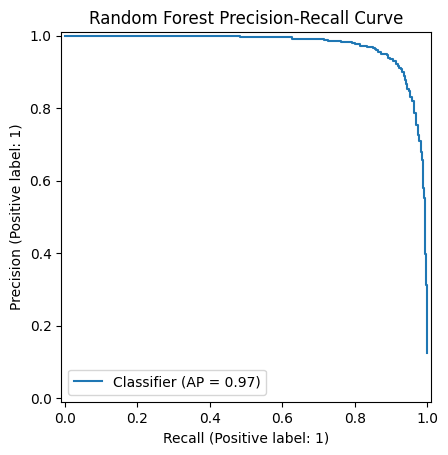

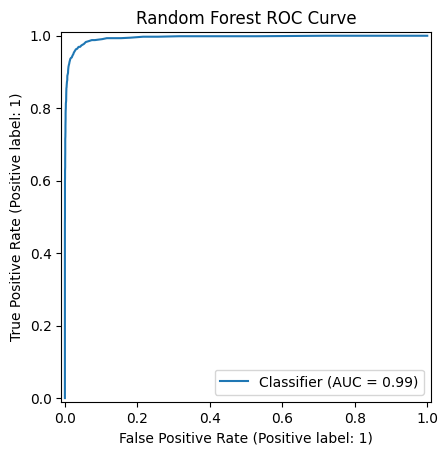

Random Forest AUC-ROC: 0.9945


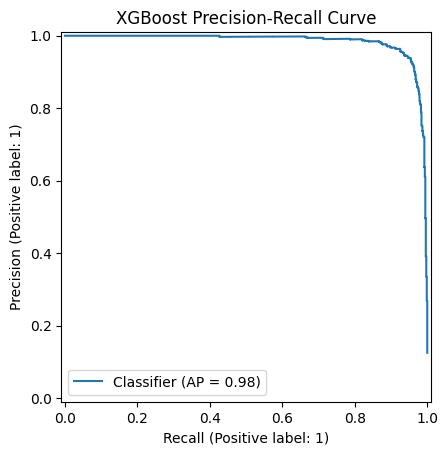

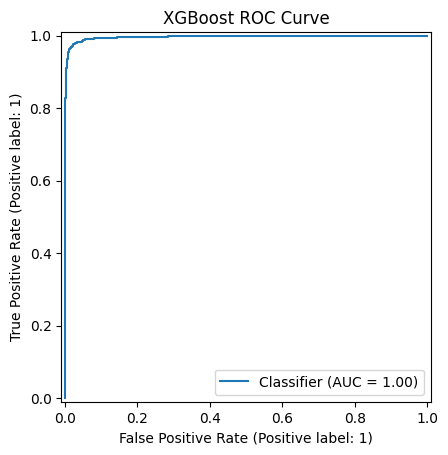

XGBoost AUC-ROC: 0.9967

=== Cross-Validation Scores ===
SVC Cross-Validation Accuracy: Mean = 0.8783, Std = 0.0013
Naive Bayes Cross-Validation Accuracy: Mean = 0.8467, Std = 0.0055
KNN Cross-Validation Accuracy: Mean = 0.8989, Std = 0.0030
Random Forest Cross-Validation Accuracy: Mean = 0.9680, Std = 0.0023


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:24:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:24:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:24:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:24:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:24:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Cross-Validation Accuracy: Mean = 0.9832, Std = 0.0021

=== Feature Importance ===

SVC Feature Importance:
               Feature  Importance
16    spectral_rolloff    0.009378
15  spectral_bandwidth    0.007542
14   spectral_centroid    0.005974
1               mfcc_1    0.000834
4               mfcc_4    0.000133


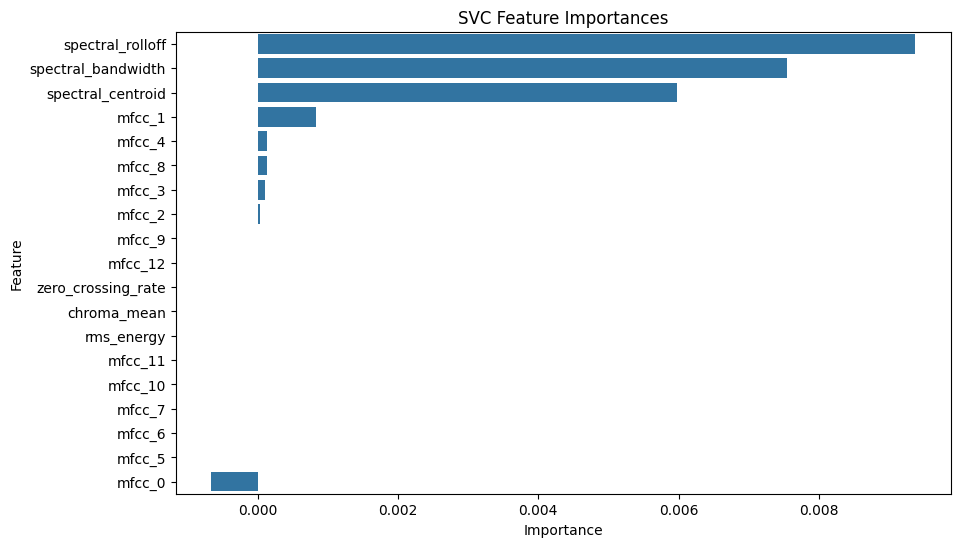


Naive Bayes Feature Importance:
        Feature  Importance
11      mfcc_11    0.007375
7        mfcc_7    0.006074
9        mfcc_9    0.002770
13  chroma_mean    0.001101
12      mfcc_12    0.001068


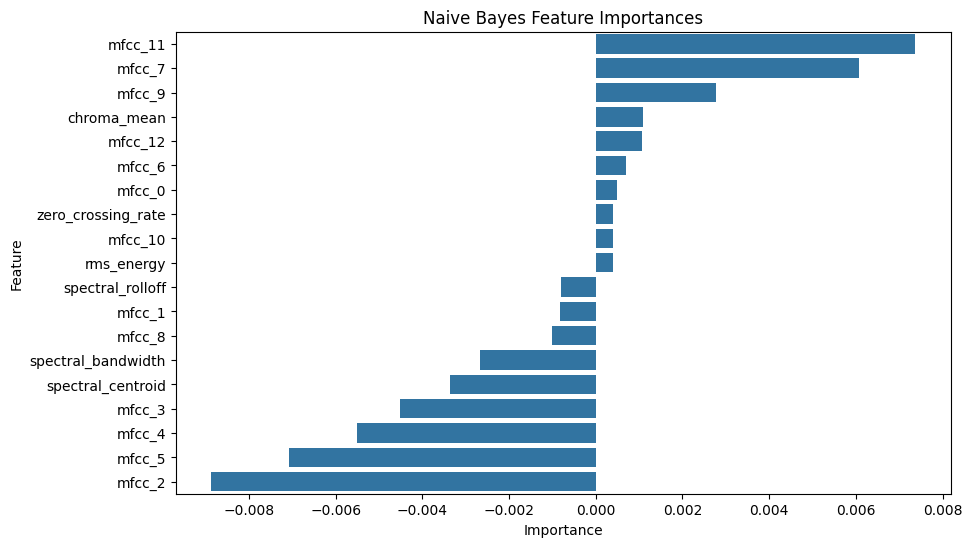


KNN Feature Importance:
               Feature  Importance
16    spectral_rolloff    0.105957
15  spectral_bandwidth    0.061205
14   spectral_centroid    0.028133
0               mfcc_0    0.007108
2               mfcc_2    0.002770


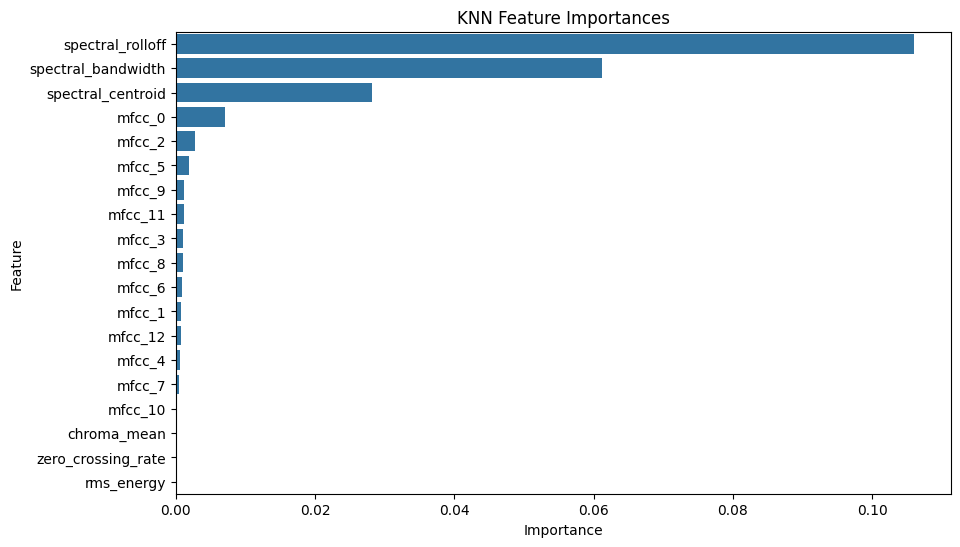


Random Forest Feature Importance:
               Feature  Importance
15  spectral_bandwidth    0.085990
11             mfcc_11    0.085030
7               mfcc_7    0.074536
8               mfcc_8    0.074276
1               mfcc_1    0.063547


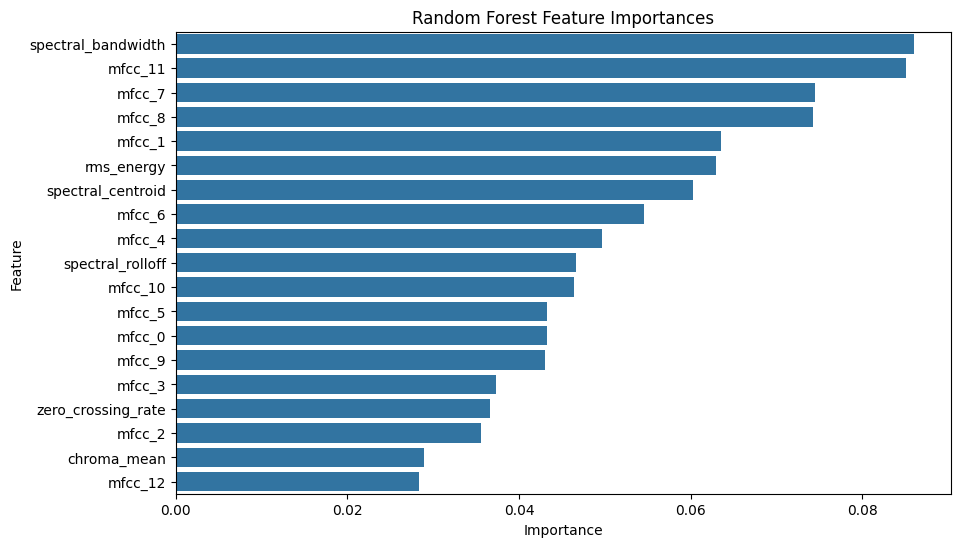


XGBoost Feature Importance:
               Feature  Importance
18          rms_energy    0.083035
1               mfcc_1    0.081844
15  spectral_bandwidth    0.081473
11             mfcc_11    0.078655
6               mfcc_6    0.076667


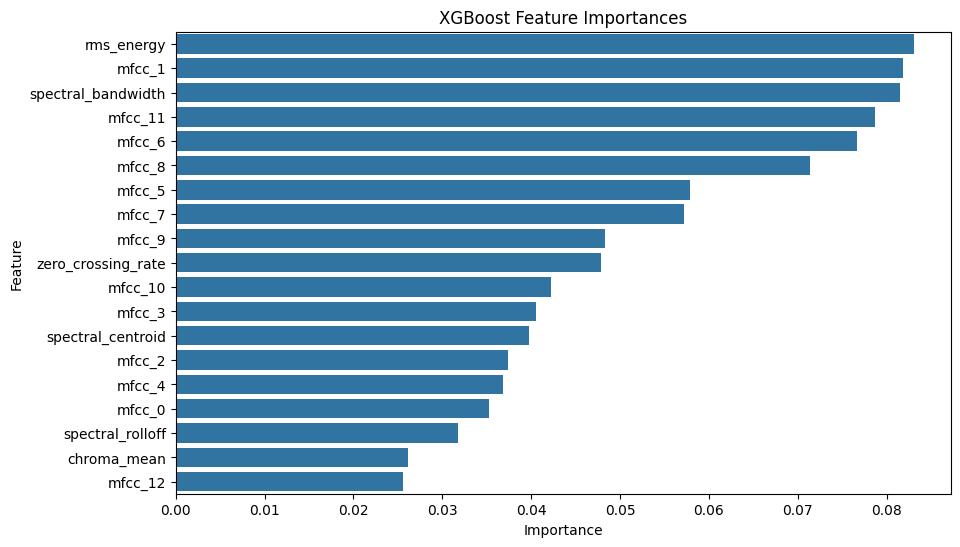


Saving the best model: XGBoost with AUC-ROC: 0.9967


In [ ]:
train_and_evaluate("/content/drive/MyDrive/KAGGLE/FAKE_audio_features_directory.csv",
                   "/content/drive/MyDrive/KAGGLE/REAL_audio_features_directory.csv", " ")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:31:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Model Performance ===

SVC Metrics:
              precision    recall  f1-score   support

        FAKE       0.89      1.00      0.94      1750
        REAL       0.94      0.13      0.22       251

    accuracy                           0.89      2001
   macro avg       0.91      0.56      0.58      2001
weighted avg       0.90      0.89      0.85      2001



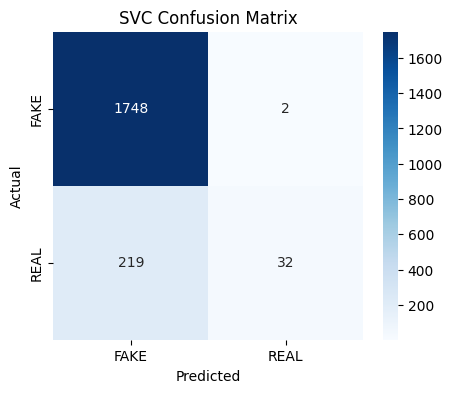


Naive Bayes Metrics:
              precision    recall  f1-score   support

        FAKE       0.94      0.92      0.93      1750
        REAL       0.51      0.56      0.53       251

    accuracy                           0.88      2001
   macro avg       0.72      0.74      0.73      2001
weighted avg       0.88      0.88      0.88      2001



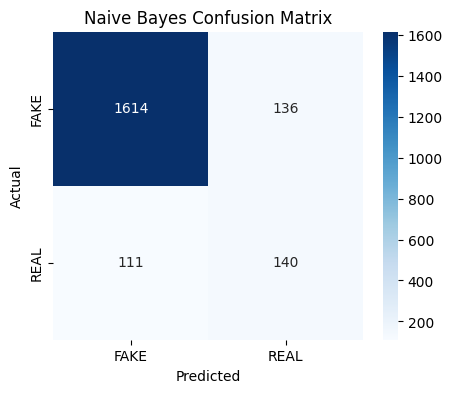


KNN Metrics:
              precision    recall  f1-score   support

        FAKE       0.91      0.98      0.95      1750
        REAL       0.72      0.35      0.47       251

    accuracy                           0.90      2001
   macro avg       0.81      0.67      0.71      2001
weighted avg       0.89      0.90      0.89      2001



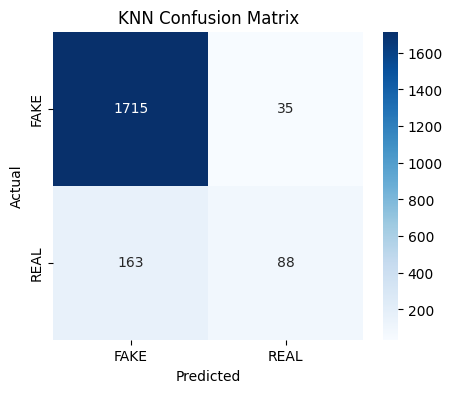


Random Forest Metrics:
              precision    recall  f1-score   support

        FAKE       0.98      1.00      0.99      1750
        REAL       1.00      0.86      0.92       251

    accuracy                           0.98      2001
   macro avg       0.99      0.93      0.96      2001
weighted avg       0.98      0.98      0.98      2001



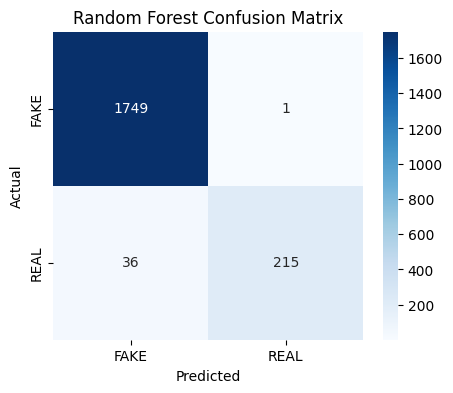


XGBoost Metrics:
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      1750
        REAL       1.00      0.97      0.98       251

    accuracy                           1.00      2001
   macro avg       1.00      0.98      0.99      2001
weighted avg       1.00      1.00      1.00      2001



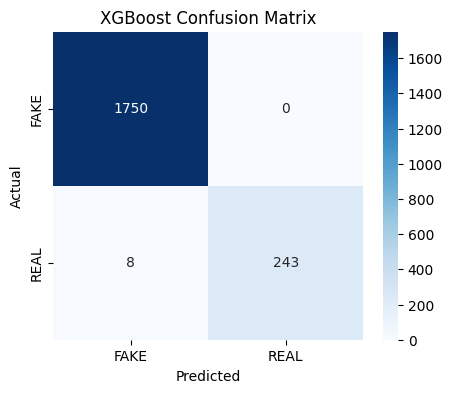


=== Precision-Recall and ROC Curves ===


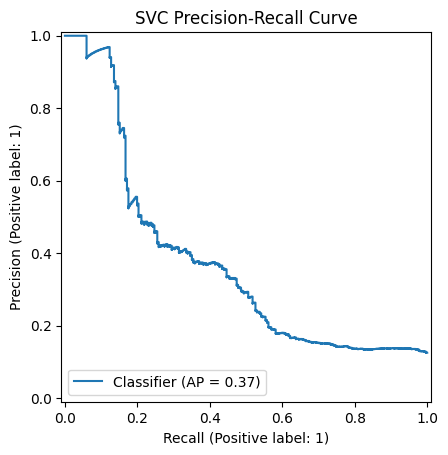

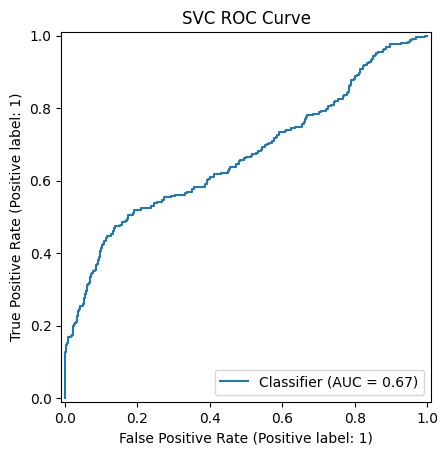

SVC AUC-ROC: 0.6683


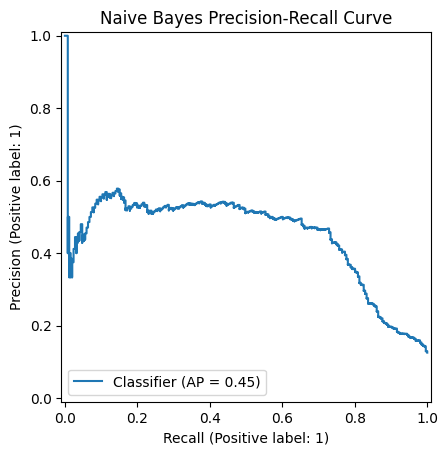

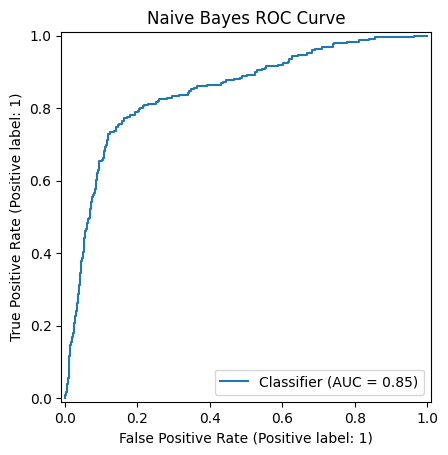

Naive Bayes AUC-ROC: 0.8470


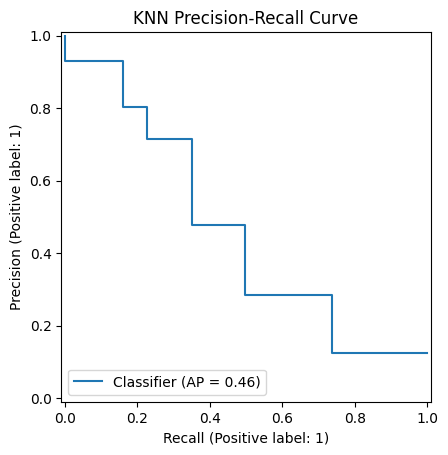

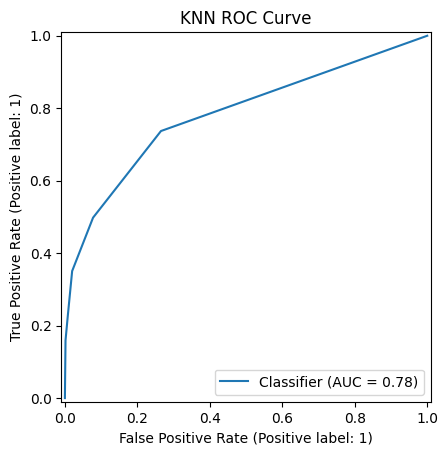

KNN AUC-ROC: 0.7833


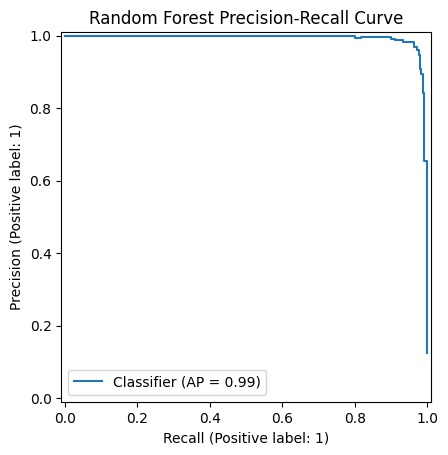

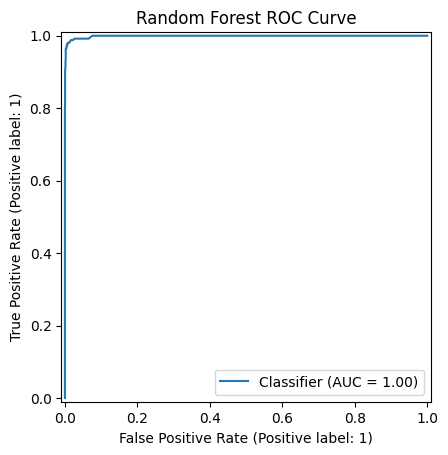

Random Forest AUC-ROC: 0.9990


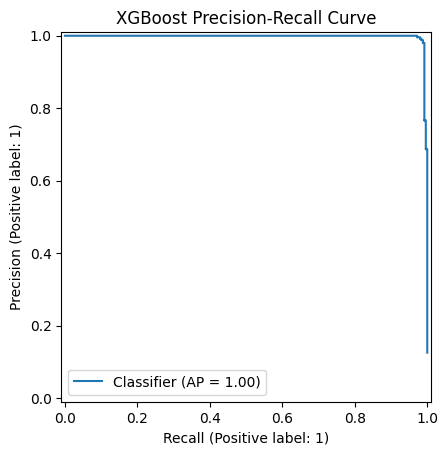

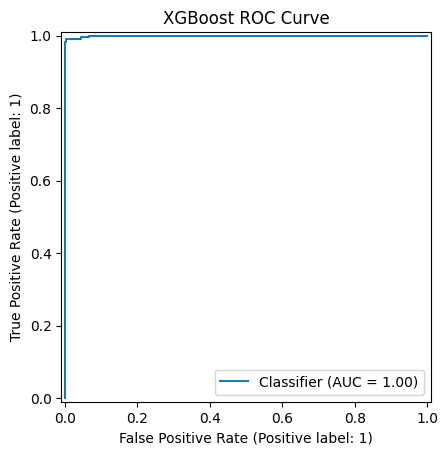

XGBoost AUC-ROC: 0.9995

=== Cross-Validation Scores ===
SVC Cross-Validation Accuracy: Mean = 0.8952, Std = 0.0024
Naive Bayes Cross-Validation Accuracy: Mean = 0.8806, Std = 0.0071
KNN Cross-Validation Accuracy: Mean = 0.9114, Std = 0.0038
Random Forest Cross-Validation Accuracy: Mean = 0.9804, Std = 0.0030


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:32:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:32:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:32:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:32:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:32:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Cross-Validation Accuracy: Mean = 0.9905, Std = 0.0027

=== Feature Importance ===

SVC Feature Importance:
               Feature  Importance
21   spectral_centroid    0.012894
22  spectral_bandwidth    0.012594
23    spectral_rolloff    0.011694
0               mfcc_0    0.000000
1               mfcc_1    0.000000


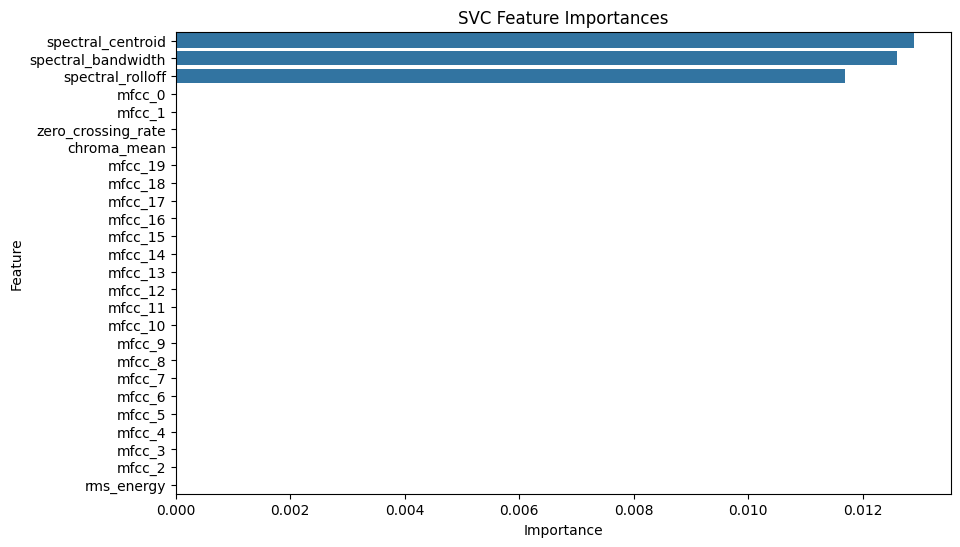


Naive Bayes Feature Importance:
    Feature  Importance
17  mfcc_17    0.007796
7    mfcc_7    0.007096
11  mfcc_11    0.006597
8    mfcc_8    0.005597
6    mfcc_6    0.004398


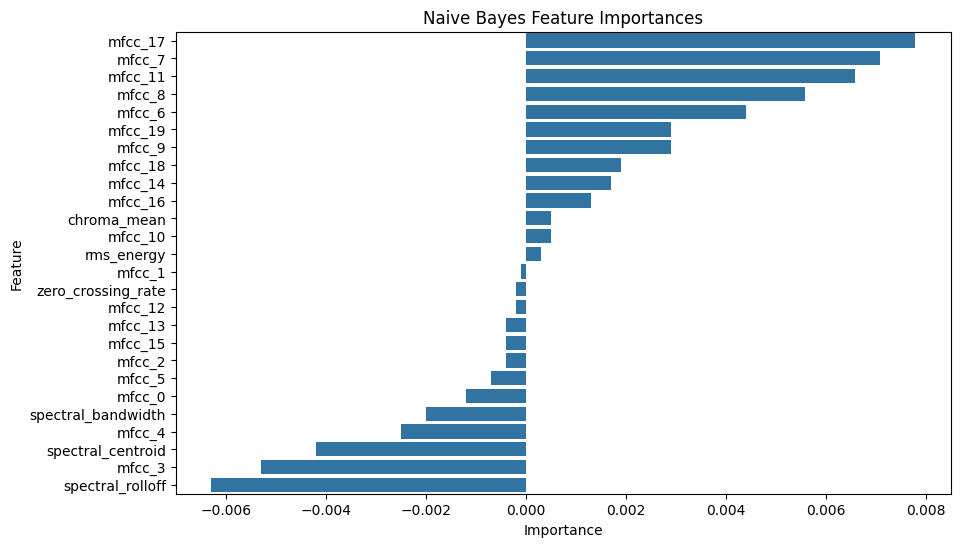


KNN Feature Importance:
               Feature  Importance
23    spectral_rolloff    0.130135
22  spectral_bandwidth    0.074163
21   spectral_centroid    0.033083
0               mfcc_0    0.008196
1               mfcc_1    0.002199


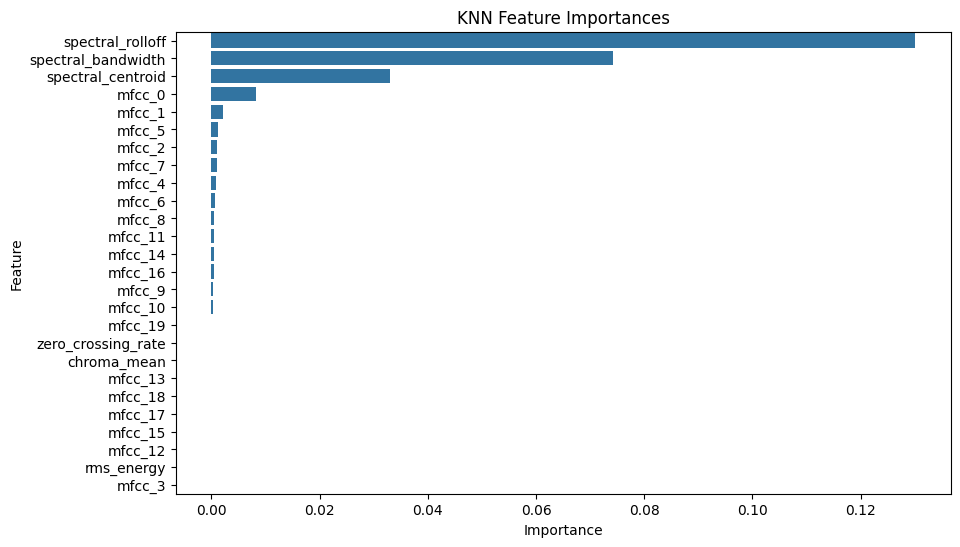


Random Forest Feature Importance:
               Feature  Importance
11             mfcc_11    0.092907
1               mfcc_1    0.078404
17             mfcc_17    0.076785
22  spectral_bandwidth    0.071439
8               mfcc_8    0.070267


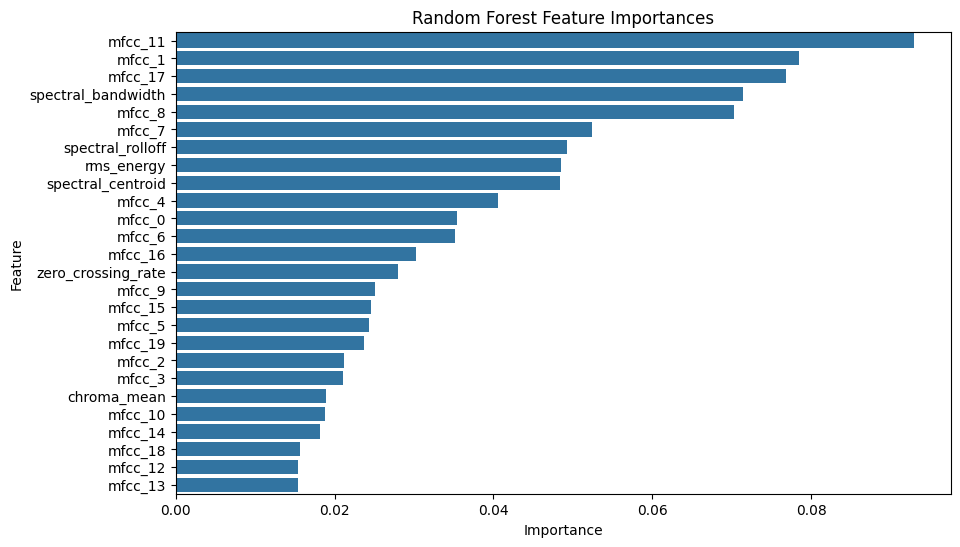


XGBoost Feature Importance:
    Feature  Importance
1    mfcc_1    0.163284
17  mfcc_17    0.133621
11  mfcc_11    0.076187
8    mfcc_8    0.068120
16  mfcc_16    0.045109


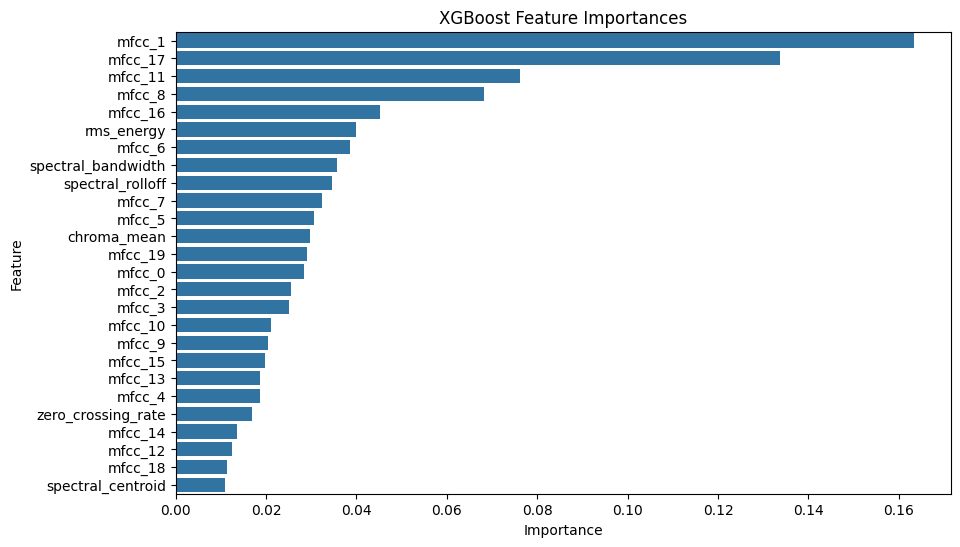


Saving the best model: XGBoost with AUC-ROC: 0.9995


In [ ]:
train_and_evaluate("/content/drive/MyDrive/KAGGLE/FAKE_audio_features_directory_3secNoOverlap.csv",
                   "/content/drive/MyDrive/KAGGLE/REAL_audio_features_directory_3secNoOverlap.csv", " ")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:33:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Model Performance ===

SVC Metrics:
              precision    recall  f1-score   support

        FAKE       0.90      1.00      0.95      1050
        REAL       1.00      0.19      0.32       151

    accuracy                           0.90      1201
   macro avg       0.95      0.60      0.63      1201
weighted avg       0.91      0.90      0.87      1201



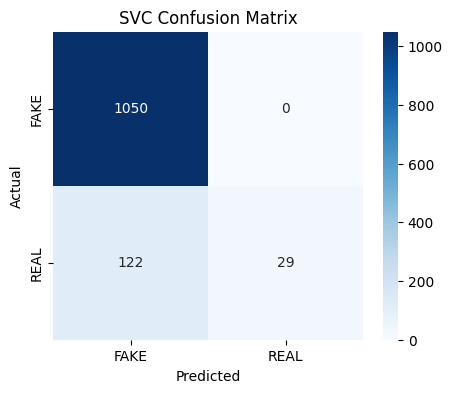


Naive Bayes Metrics:
              precision    recall  f1-score   support

        FAKE       0.95      0.93      0.94      1050
        REAL       0.58      0.69      0.63       151

    accuracy                           0.90      1201
   macro avg       0.77      0.81      0.78      1201
weighted avg       0.91      0.90      0.90      1201



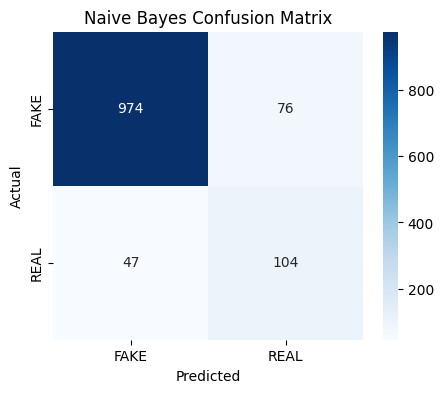


KNN Metrics:
              precision    recall  f1-score   support

        FAKE       0.93      0.98      0.95      1050
        REAL       0.74      0.48      0.58       151

    accuracy                           0.91      1201
   macro avg       0.83      0.73      0.77      1201
weighted avg       0.91      0.91      0.91      1201



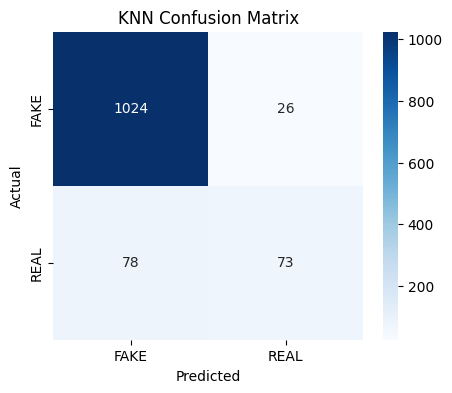


Random Forest Metrics:
              precision    recall  f1-score   support

        FAKE       0.99      1.00      0.99      1050
        REAL       1.00      0.92      0.96       151

    accuracy                           0.99      1201
   macro avg       0.99      0.96      0.98      1201
weighted avg       0.99      0.99      0.99      1201



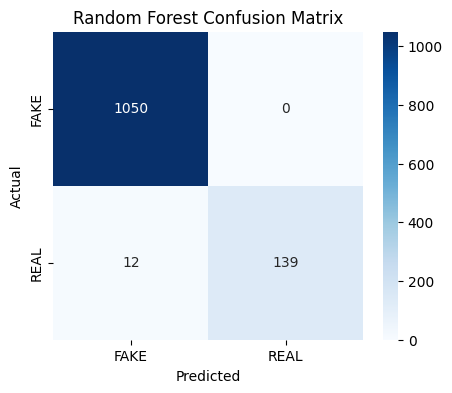


XGBoost Metrics:
              precision    recall  f1-score   support

        FAKE       0.99      1.00      1.00      1050
        REAL       0.99      0.95      0.97       151

    accuracy                           0.99      1201
   macro avg       0.99      0.97      0.98      1201
weighted avg       0.99      0.99      0.99      1201



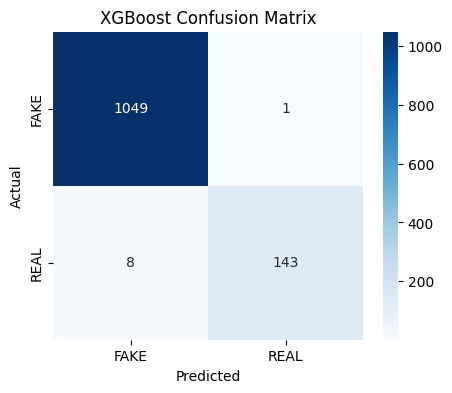


=== Precision-Recall and ROC Curves ===


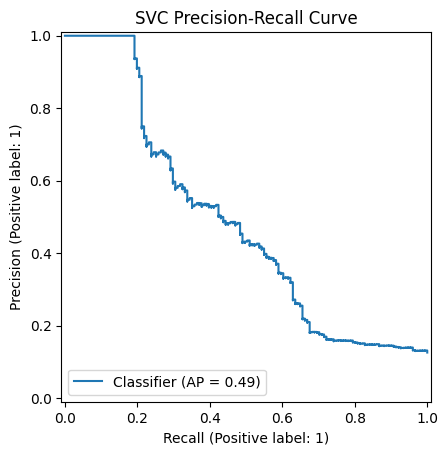

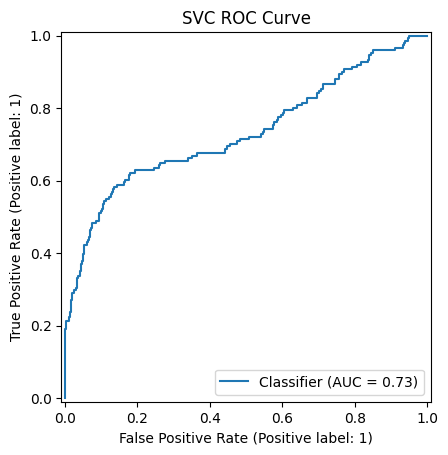

SVC AUC-ROC: 0.7320


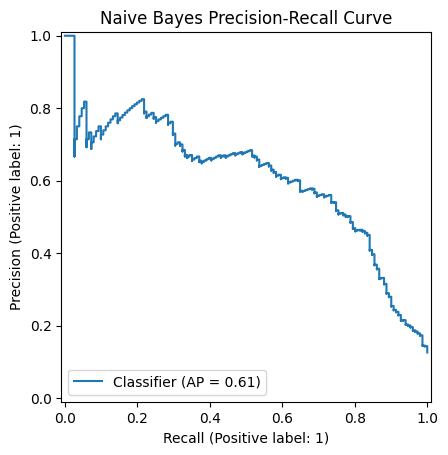

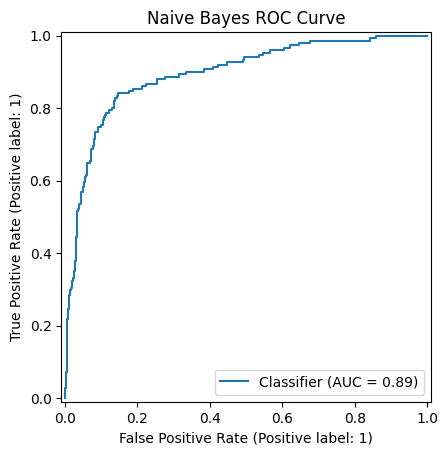

Naive Bayes AUC-ROC: 0.8945


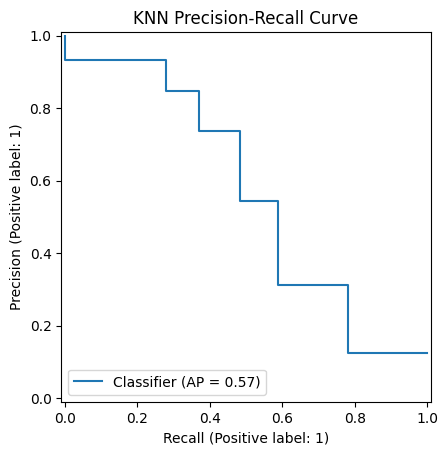

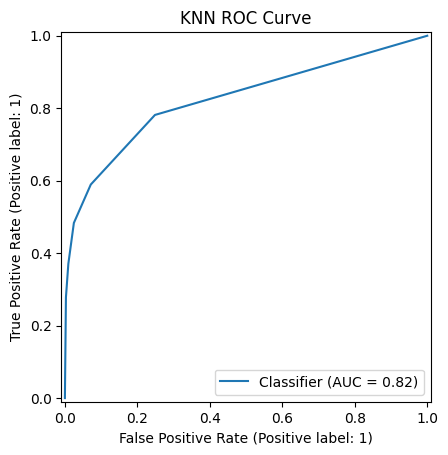

KNN AUC-ROC: 0.8248


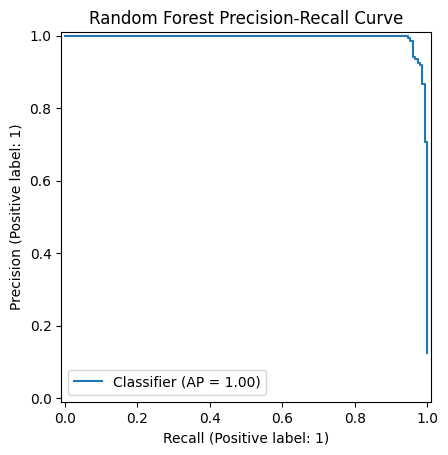

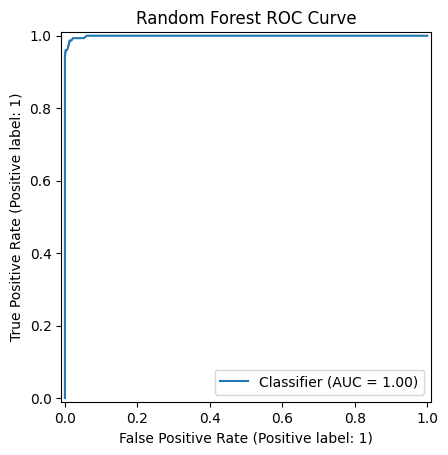

Random Forest AUC-ROC: 0.9992


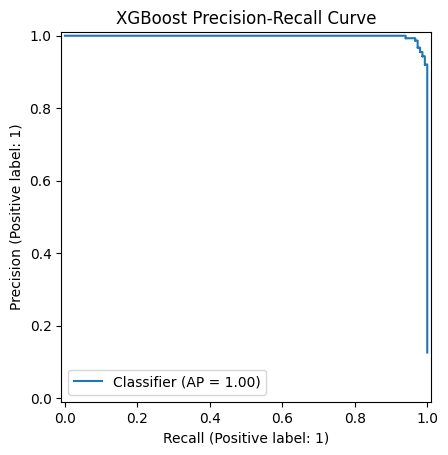

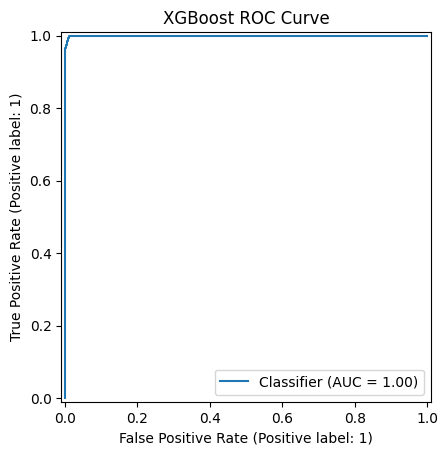

XGBoost AUC-ROC: 0.9997

=== Cross-Validation Scores ===
SVC Cross-Validation Accuracy: Mean = 0.8930, Std = 0.0055
Naive Bayes Cross-Validation Accuracy: Mean = 0.9028, Std = 0.0119
KNN Cross-Validation Accuracy: Mean = 0.9117, Std = 0.0064
Random Forest Cross-Validation Accuracy: Mean = 0.9827, Std = 0.0028


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:34:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:34:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:34:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:34:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:34:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Cross-Validation Accuracy: Mean = 0.9898, Std = 0.0032

=== Feature Importance ===

SVC Feature Importance:
               Feature  Importance
23    spectral_rolloff    0.020983
21   spectral_centroid    0.019650
22  spectral_bandwidth    0.015154
0               mfcc_0    0.000000
1               mfcc_1    0.000000


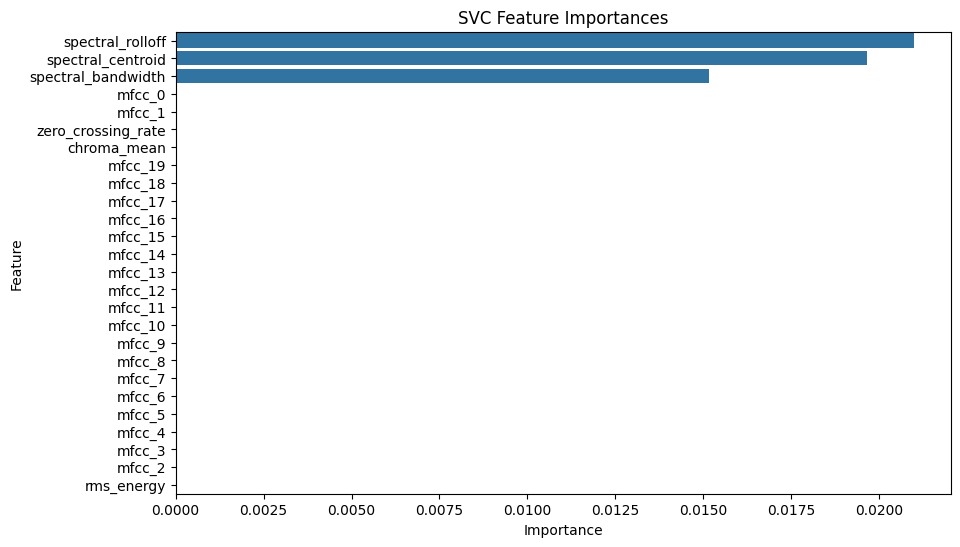


Naive Bayes Feature Importance:
    Feature  Importance
1    mfcc_1    0.008326
8    mfcc_8    0.007993
7    mfcc_7    0.005662
11  mfcc_11    0.005495
17  mfcc_17    0.004996


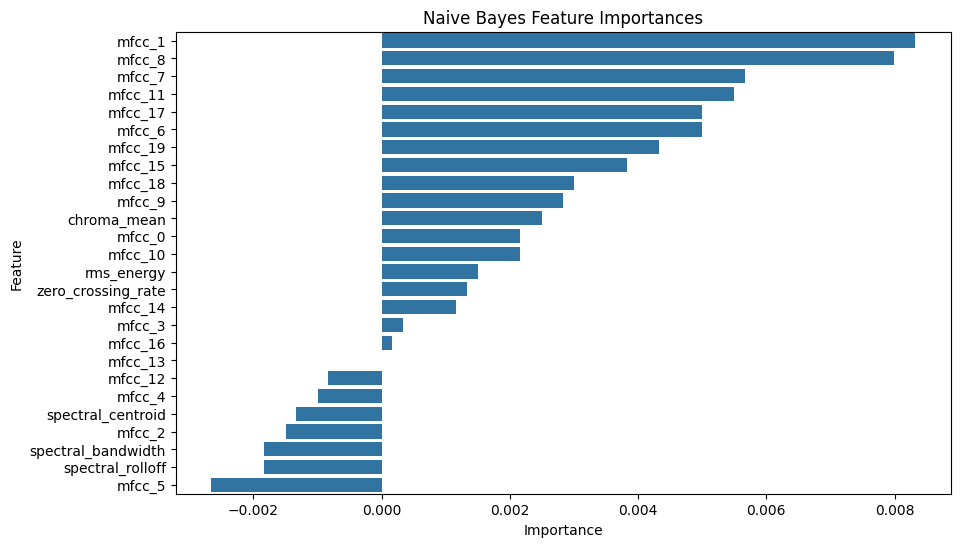


KNN Feature Importance:
               Feature  Importance
23    spectral_rolloff    0.139051
22  spectral_bandwidth    0.085262
21   spectral_centroid    0.021482
0               mfcc_0    0.003997
1               mfcc_1    0.001499


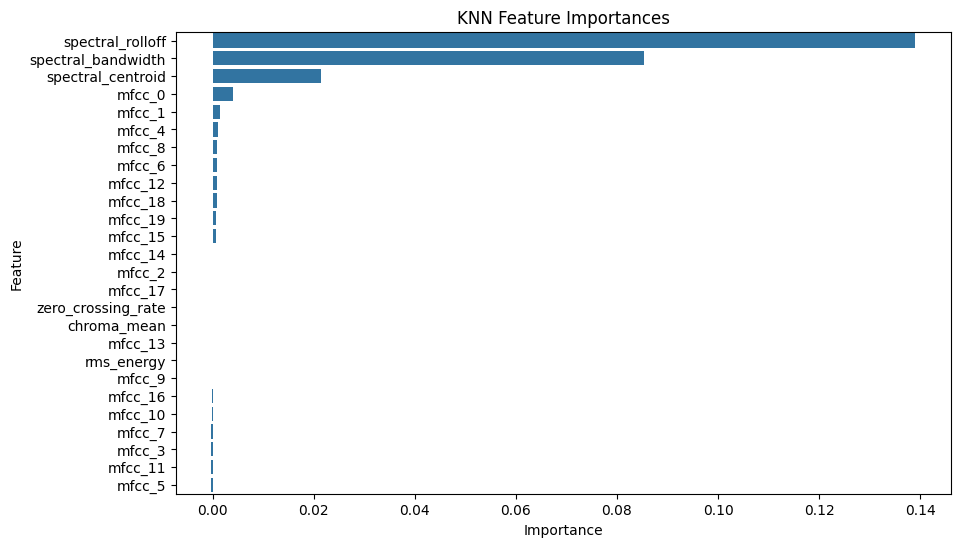


Random Forest Feature Importance:
               Feature  Importance
1               mfcc_1    0.107390
11             mfcc_11    0.095605
17             mfcc_17    0.078377
8               mfcc_8    0.074399
22  spectral_bandwidth    0.061341


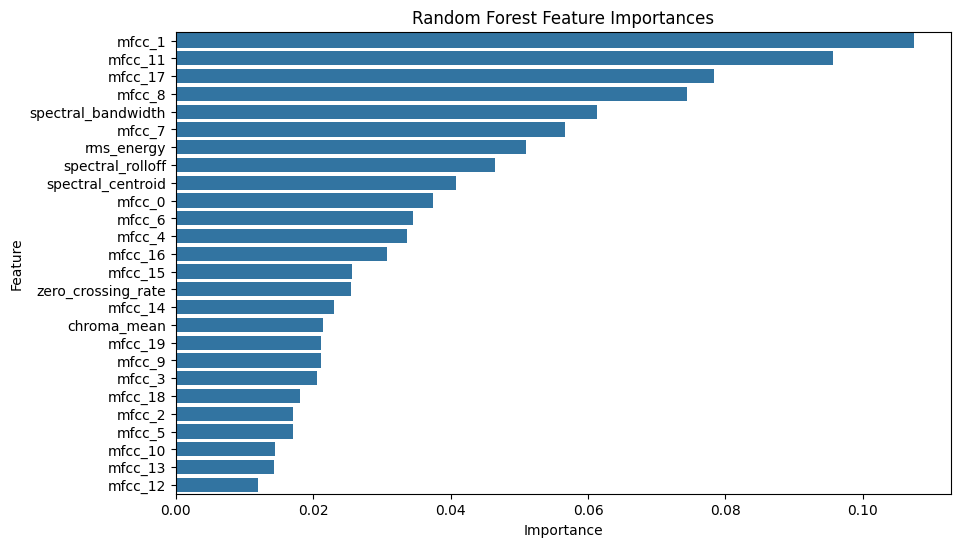


XGBoost Feature Importance:
    Feature  Importance
17  mfcc_17    0.126279
1    mfcc_1    0.122303
11  mfcc_11    0.091526
8    mfcc_8    0.059792
16  mfcc_16    0.055112


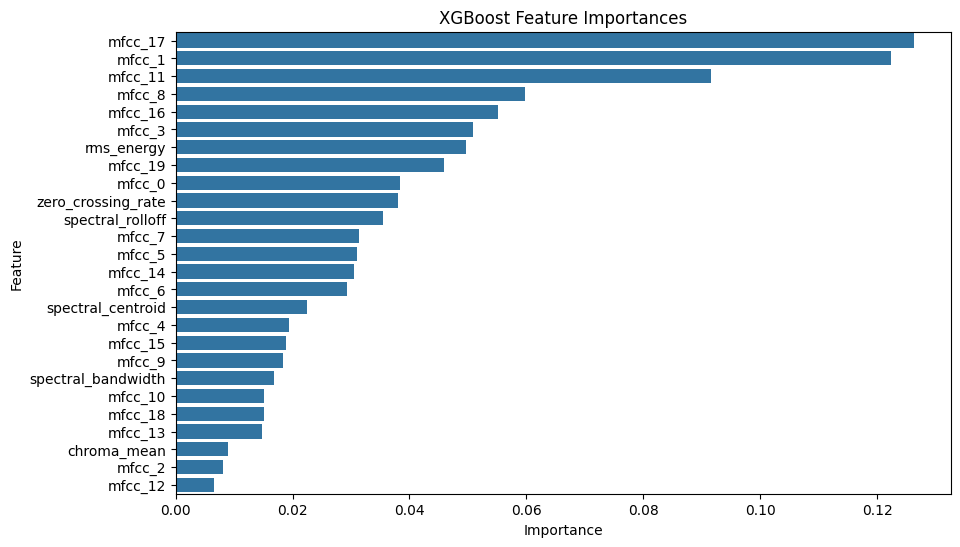


Saving the best model: XGBoost with AUC-ROC: 0.9997


In [ ]:
train_and_evaluate("/content/drive/MyDrive/KAGGLE/FAKE_audio_features_directory_5secNoOverlap.csv",
                   "/content/drive/MyDrive/KAGGLE/REAL_audio_features_directory_5secNoOverlap.csv", " ")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:34:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Model Performance ===

SVC Metrics:
              precision    recall  f1-score   support

        FAKE       0.89      1.00      0.94       527
        REAL       1.00      0.14      0.25        76

    accuracy                           0.89       603
   macro avg       0.95      0.57      0.60       603
weighted avg       0.90      0.89      0.86       603



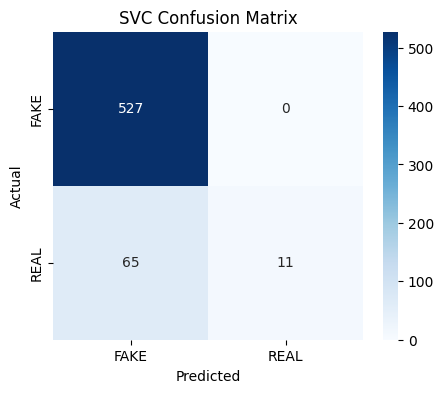


Naive Bayes Metrics:
              precision    recall  f1-score   support

        FAKE       0.96      0.97      0.97       527
        REAL       0.78      0.74      0.76        76

    accuracy                           0.94       603
   macro avg       0.87      0.85      0.86       603
weighted avg       0.94      0.94      0.94       603



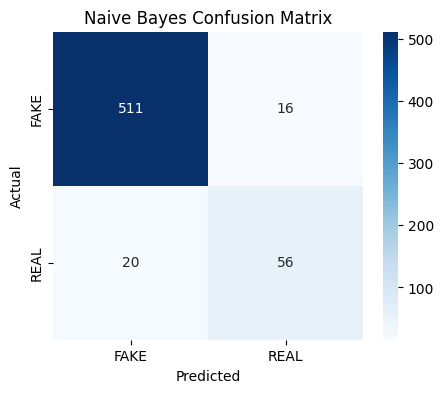


KNN Metrics:
              precision    recall  f1-score   support

        FAKE       0.93      0.98      0.95       527
        REAL       0.80      0.47      0.60        76

    accuracy                           0.92       603
   macro avg       0.86      0.73      0.77       603
weighted avg       0.91      0.92      0.91       603



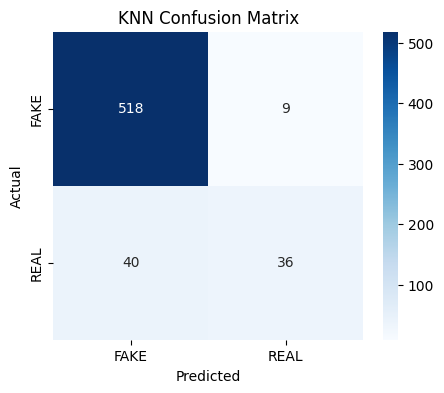


Random Forest Metrics:
              precision    recall  f1-score   support

        FAKE       0.99      1.00      0.99       527
        REAL       0.99      0.92      0.95        76

    accuracy                           0.99       603
   macro avg       0.99      0.96      0.97       603
weighted avg       0.99      0.99      0.99       603



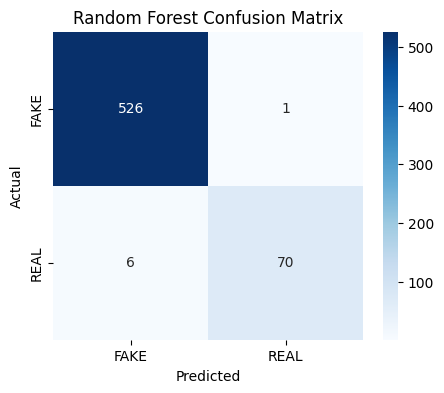


XGBoost Metrics:
              precision    recall  f1-score   support

        FAKE       0.99      1.00      1.00       527
        REAL       1.00      0.93      0.97        76

    accuracy                           0.99       603
   macro avg       1.00      0.97      0.98       603
weighted avg       0.99      0.99      0.99       603



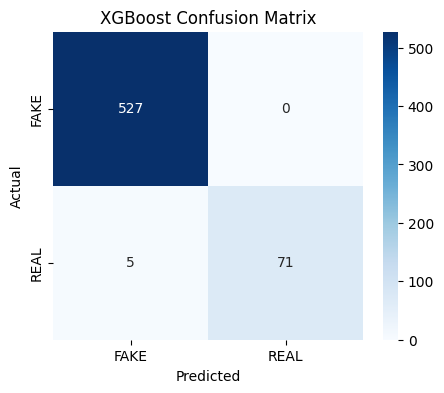


=== Precision-Recall and ROC Curves ===


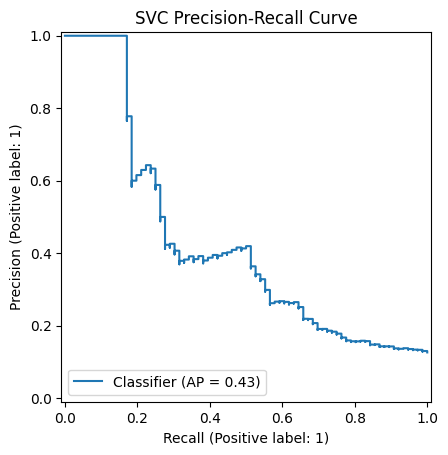

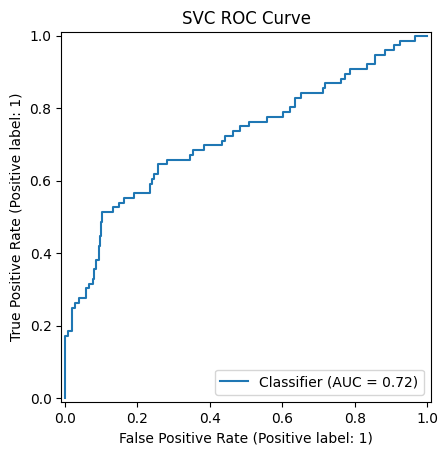

SVC AUC-ROC: 0.7207


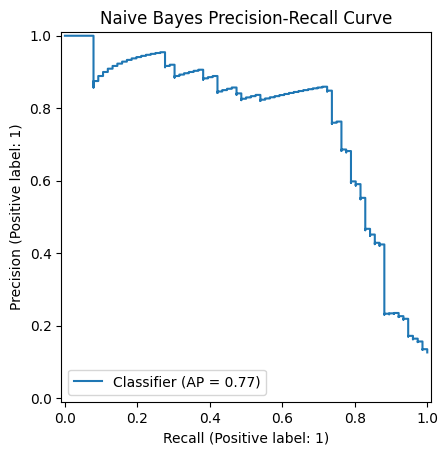

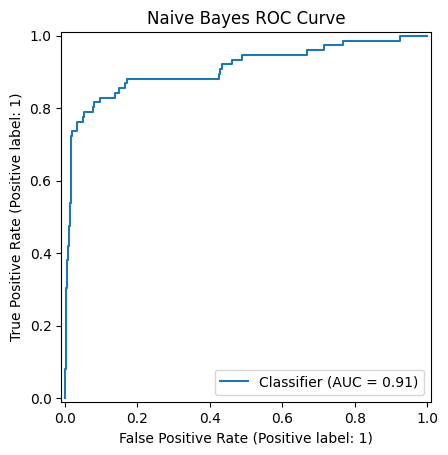

Naive Bayes AUC-ROC: 0.9100


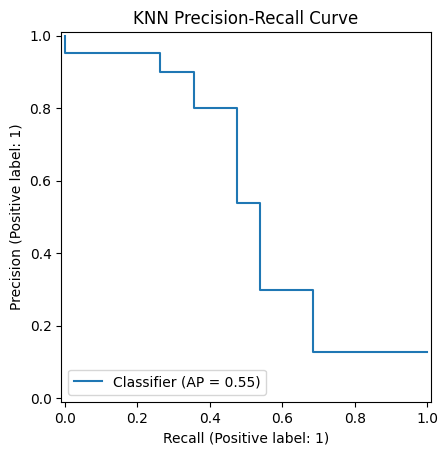

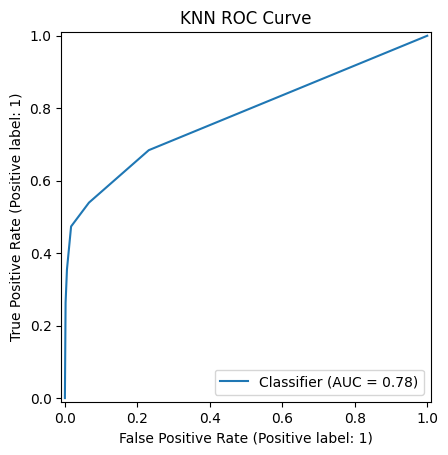

KNN AUC-ROC: 0.7793


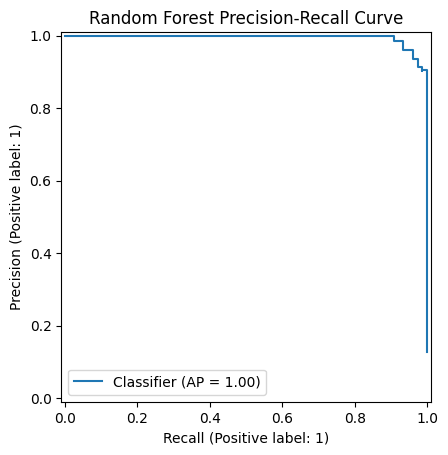

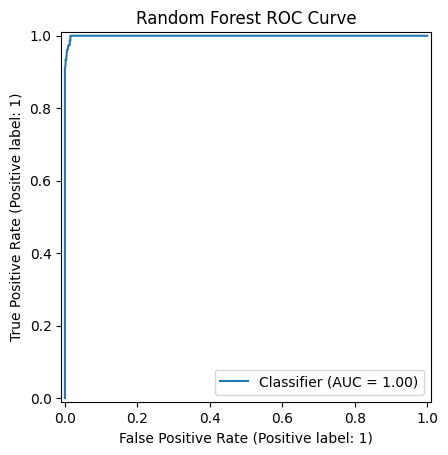

Random Forest AUC-ROC: 0.9994


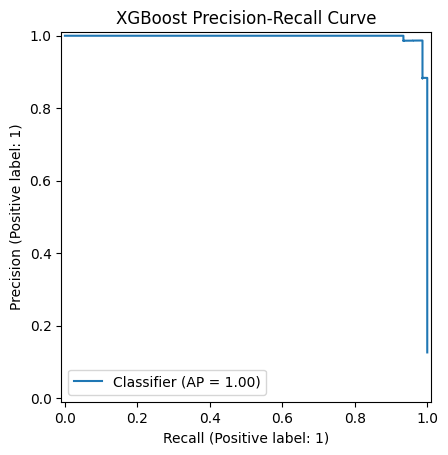

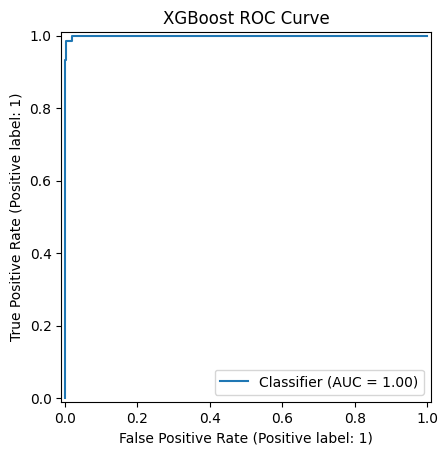

XGBoost AUC-ROC: 0.9997

=== Cross-Validation Scores ===
SVC Cross-Validation Accuracy: Mean = 0.8929, Std = 0.0057
Naive Bayes Cross-Validation Accuracy: Mean = 0.9344, Std = 0.0086
KNN Cross-Validation Accuracy: Mean = 0.9170, Std = 0.0095
Random Forest Cross-Validation Accuracy: Mean = 0.9863, Std = 0.0031


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:34:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:34:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:34:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:34:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:34:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Cross-Validation Accuracy: Mean = 0.9917, Std = 0.0044

=== Feature Importance ===

SVC Feature Importance:
               Feature  Importance
23    spectral_rolloff    0.016915
21   spectral_centroid    0.013930
22  spectral_bandwidth    0.002985
0               mfcc_0    0.000000
1               mfcc_1    0.000000


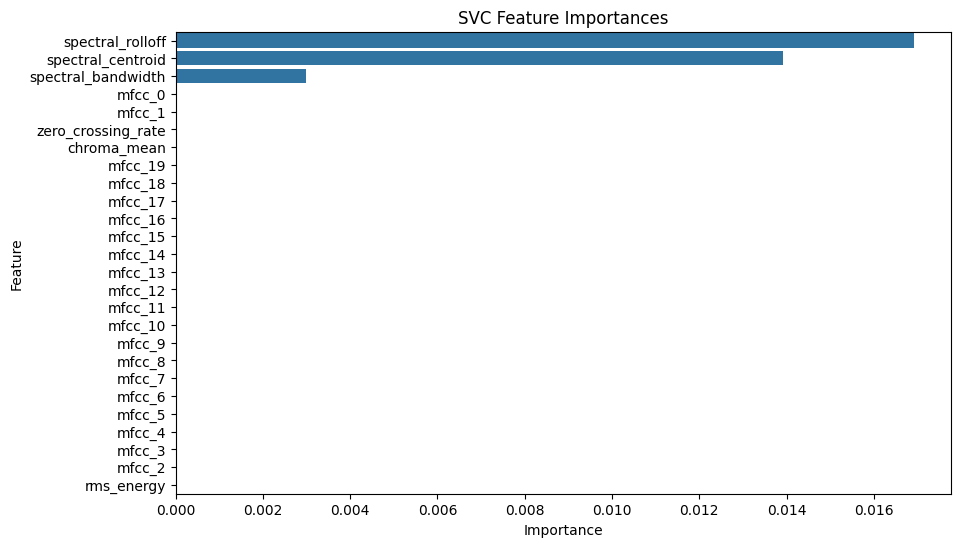


Naive Bayes Feature Importance:
               Feature  Importance
11             mfcc_11    0.012272
1               mfcc_1    0.006965
7               mfcc_7    0.006633
22  spectral_bandwidth    0.005638
8               mfcc_8    0.004975


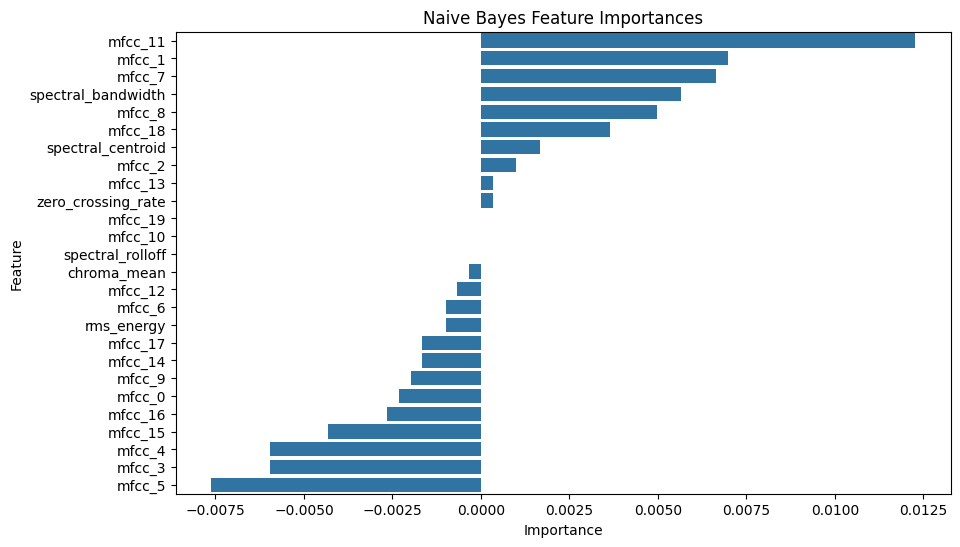


KNN Feature Importance:
               Feature  Importance
23    spectral_rolloff    0.143284
22  spectral_bandwidth    0.075290
21   spectral_centroid    0.033831
0               mfcc_0    0.003317
2               mfcc_2    0.003317


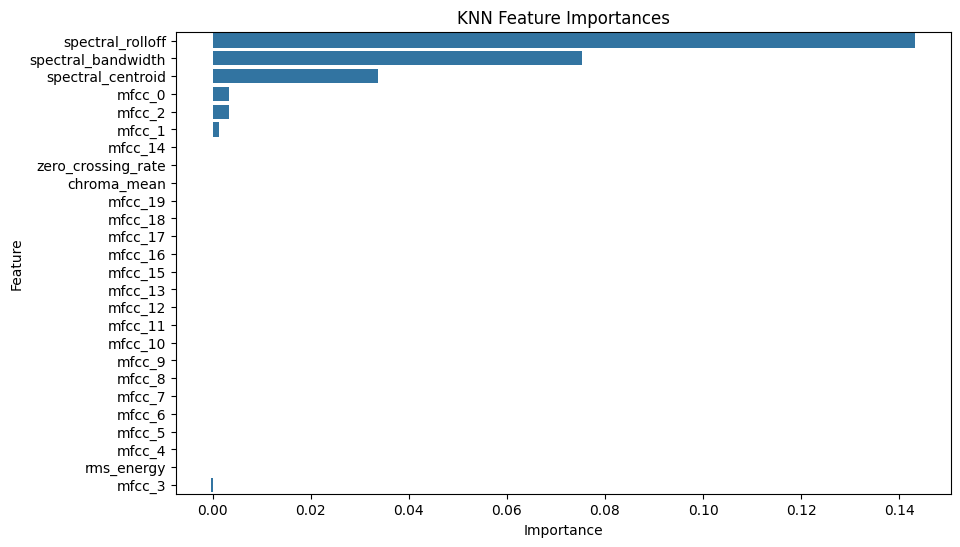


Random Forest Feature Importance:
       Feature  Importance
1       mfcc_1    0.137972
11     mfcc_11    0.102881
8       mfcc_8    0.091197
7       mfcc_7    0.069008
25  rms_energy    0.064056


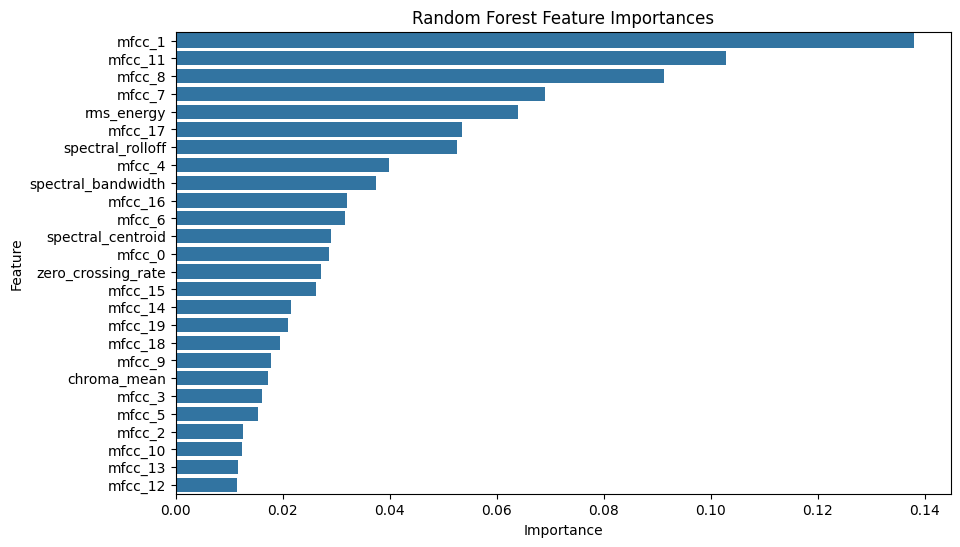


XGBoost Feature Importance:
    Feature  Importance
1    mfcc_1    0.163065
8    mfcc_8    0.111864
11  mfcc_11    0.090510
18  mfcc_18    0.089641
3    mfcc_3    0.080802


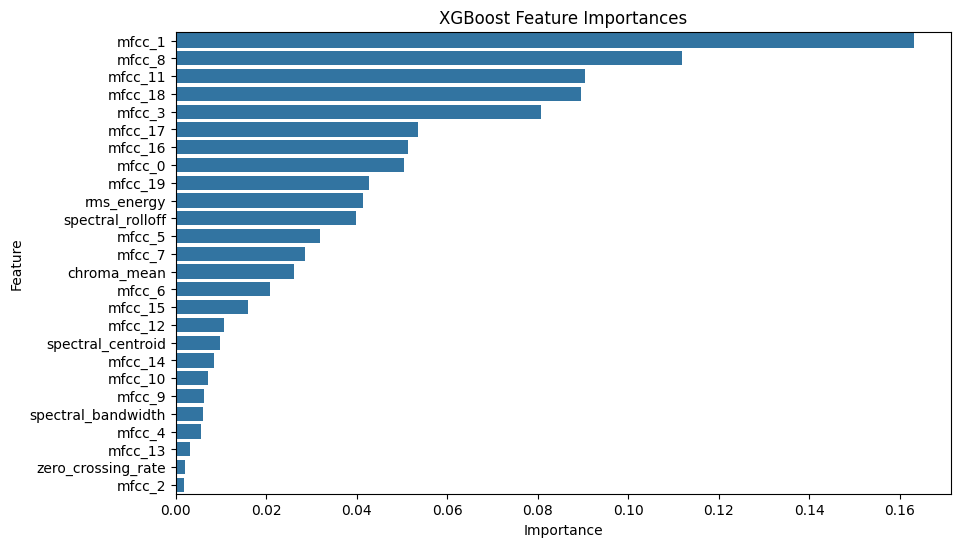


Saving the best model: XGBoost with AUC-ROC: 0.9997


In [ ]:
train_and_evaluate("/content/drive/MyDrive/KAGGLE/FAKE_audio_features_directory_10secNoOverlap.csv",
                   "/content/drive/MyDrive/KAGGLE/REAL_audio_features_directory_10secNoOverlap.csv", " ")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:35:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Model Performance ===

SVC Metrics:
              precision    recall  f1-score   support

        FAKE       0.89      1.00      0.94      2086
        REAL       0.94      0.17      0.28       298

    accuracy                           0.89      2384
   macro avg       0.92      0.58      0.61      2384
weighted avg       0.90      0.89      0.86      2384



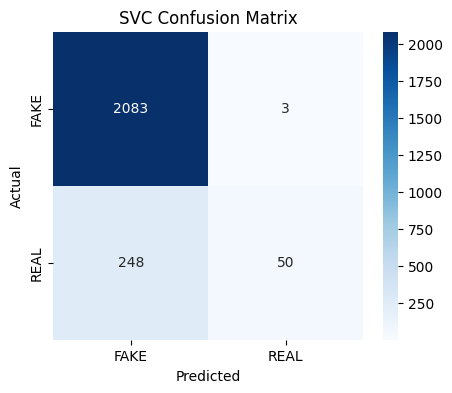


Naive Bayes Metrics:
              precision    recall  f1-score   support

        FAKE       0.94      0.91      0.93      2086
        REAL       0.50      0.59      0.54       298

    accuracy                           0.87      2384
   macro avg       0.72      0.75      0.73      2384
weighted avg       0.88      0.87      0.88      2384



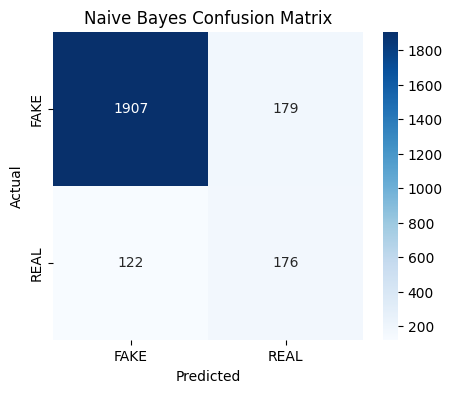


KNN Metrics:
              precision    recall  f1-score   support

        FAKE       0.92      0.97      0.95      2086
        REAL       0.69      0.44      0.54       298

    accuracy                           0.90      2384
   macro avg       0.80      0.71      0.74      2384
weighted avg       0.89      0.90      0.90      2384



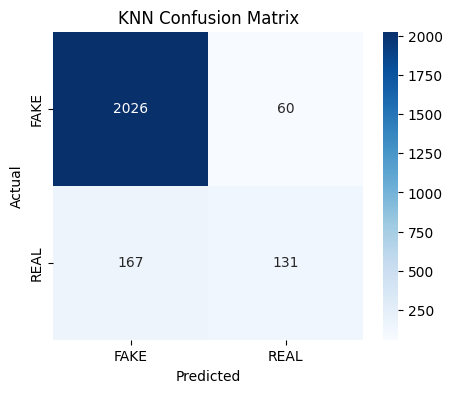


Random Forest Metrics:
              precision    recall  f1-score   support

        FAKE       0.98      1.00      0.99      2086
        REAL       1.00      0.87      0.93       298

    accuracy                           0.98      2384
   macro avg       0.99      0.93      0.96      2384
weighted avg       0.98      0.98      0.98      2384



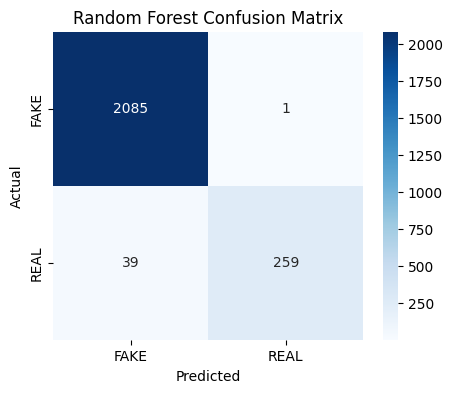


XGBoost Metrics:
              precision    recall  f1-score   support

        FAKE       0.99      1.00      1.00      2086
        REAL       0.99      0.94      0.97       298

    accuracy                           0.99      2384
   macro avg       0.99      0.97      0.98      2384
weighted avg       0.99      0.99      0.99      2384



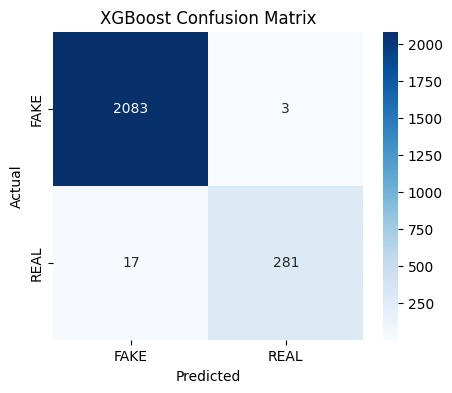


=== Precision-Recall and ROC Curves ===


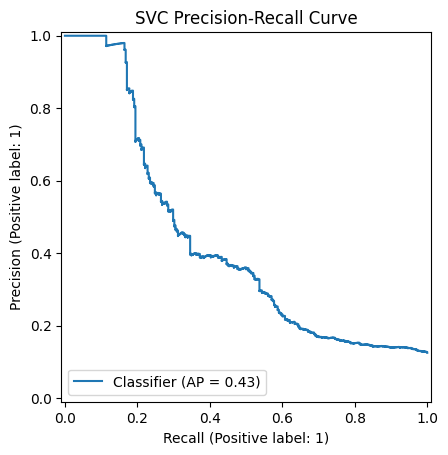

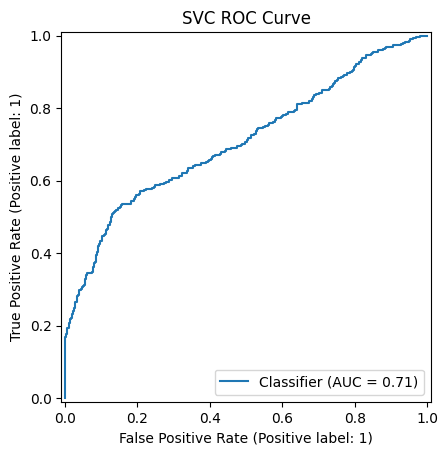

SVC AUC-ROC: 0.7081


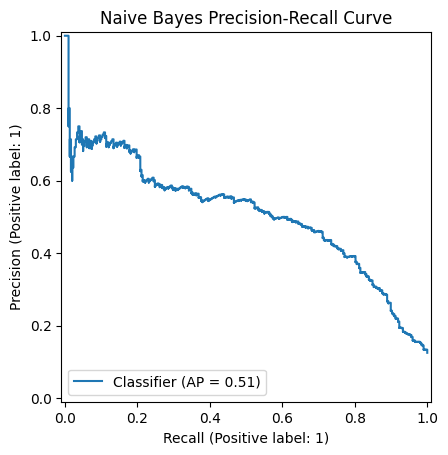

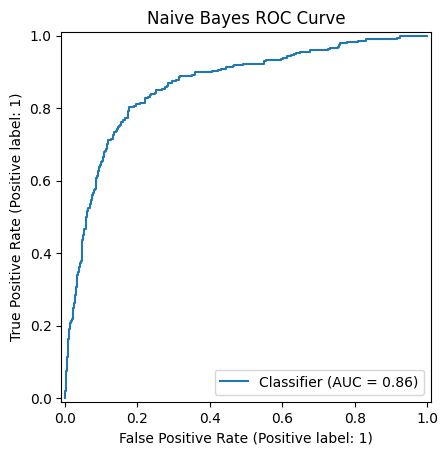

Naive Bayes AUC-ROC: 0.8631


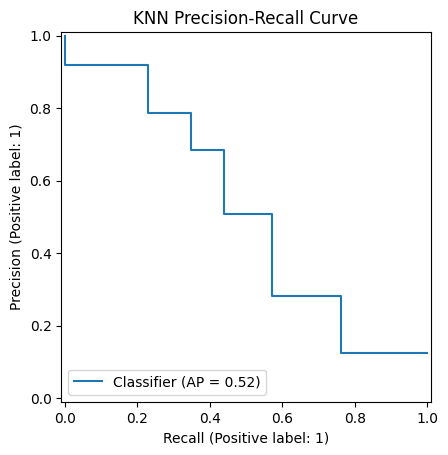

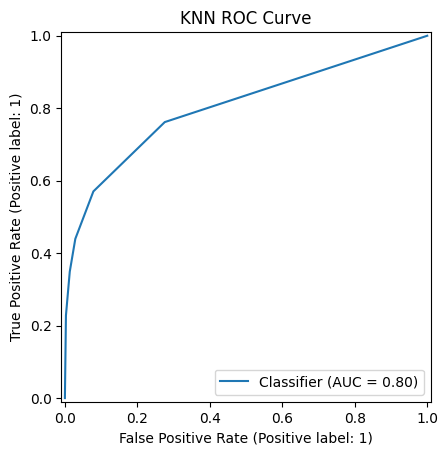

KNN AUC-ROC: 0.8039


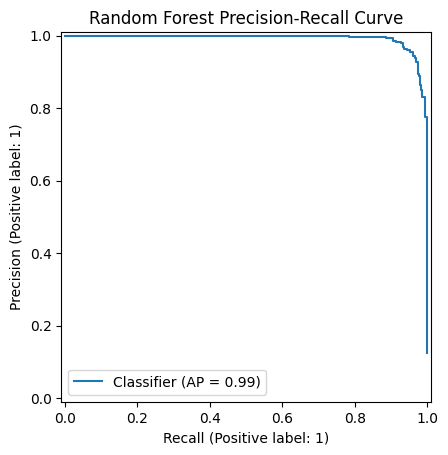

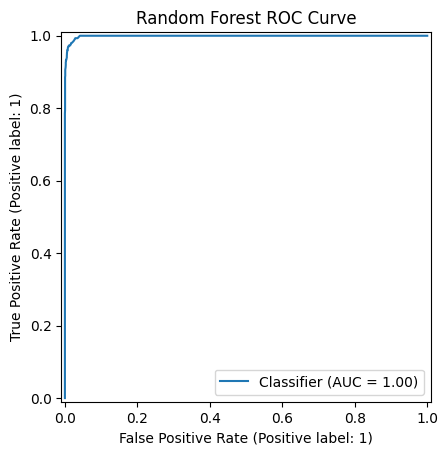

Random Forest AUC-ROC: 0.9989


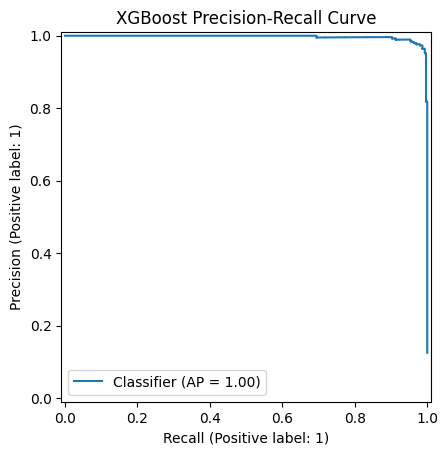

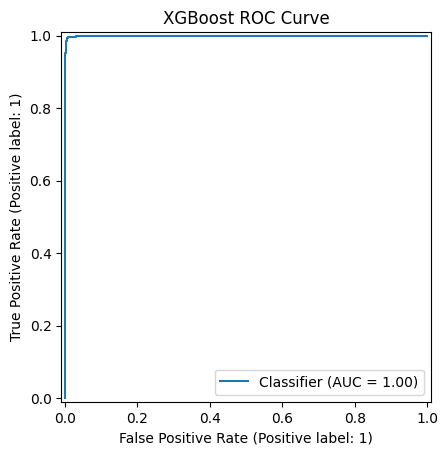

XGBoost AUC-ROC: 0.9996

=== Cross-Validation Scores ===
SVC Cross-Validation Accuracy: Mean = 0.8941, Std = 0.0027
Naive Bayes Cross-Validation Accuracy: Mean = 0.8828, Std = 0.0014
KNN Cross-Validation Accuracy: Mean = 0.9155, Std = 0.0032
Random Forest Cross-Validation Accuracy: Mean = 0.9828, Std = 0.0022


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:36:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:36:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:37:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:37:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:37:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Cross-Validation Accuracy: Mean = 0.9919, Std = 0.0017

=== Feature Importance ===

SVC Feature Importance:
               Feature  Importance
23    spectral_rolloff    0.018540
21   spectral_centroid    0.017198
22  spectral_bandwidth    0.015101
0               mfcc_0    0.000000
1               mfcc_1    0.000000


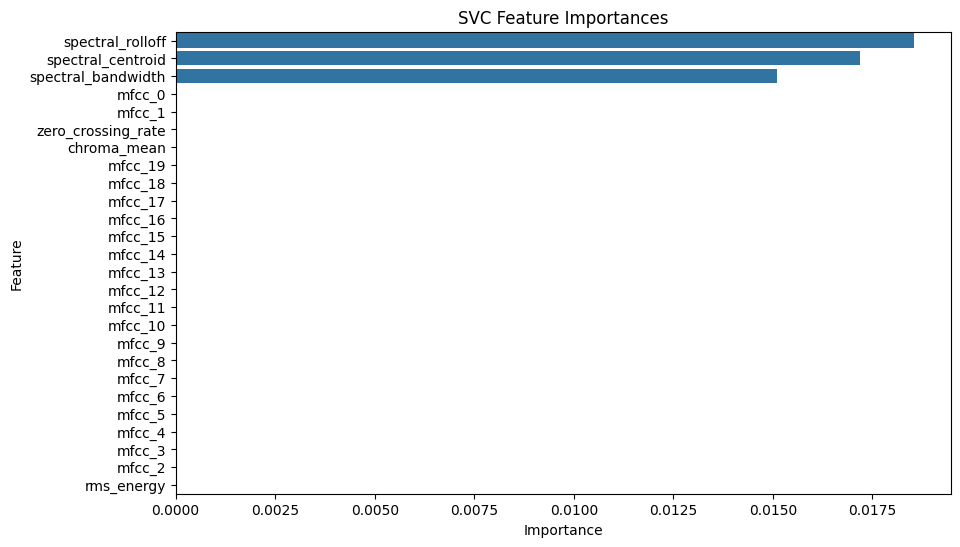


Naive Bayes Feature Importance:
    Feature  Importance
17  mfcc_17    0.006460
7    mfcc_7    0.005705
11  mfcc_11    0.003691
8    mfcc_8    0.002013
9    mfcc_9    0.001678


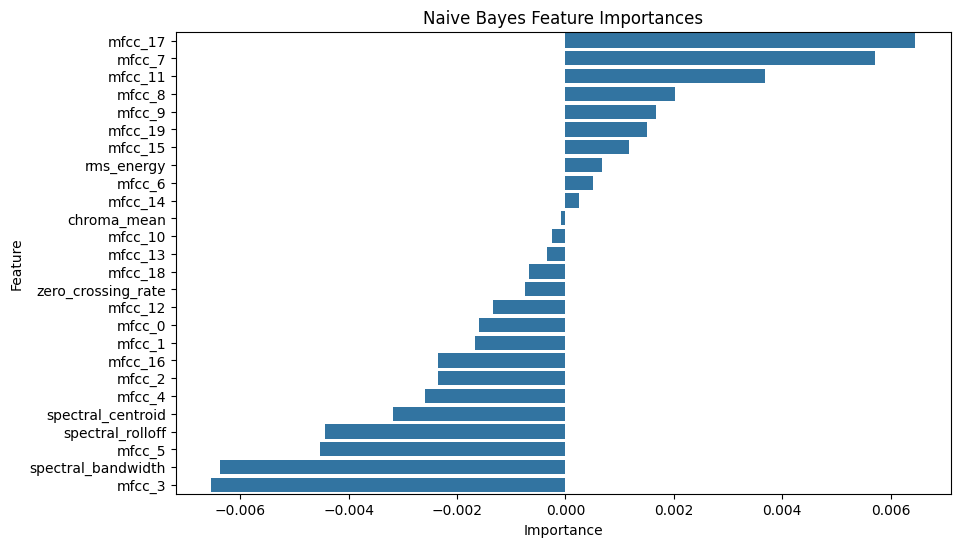


KNN Feature Importance:
               Feature  Importance
23    spectral_rolloff    0.134899
22  spectral_bandwidth    0.083138
21   spectral_centroid    0.038507
0               mfcc_0    0.006711
2               mfcc_2    0.003943


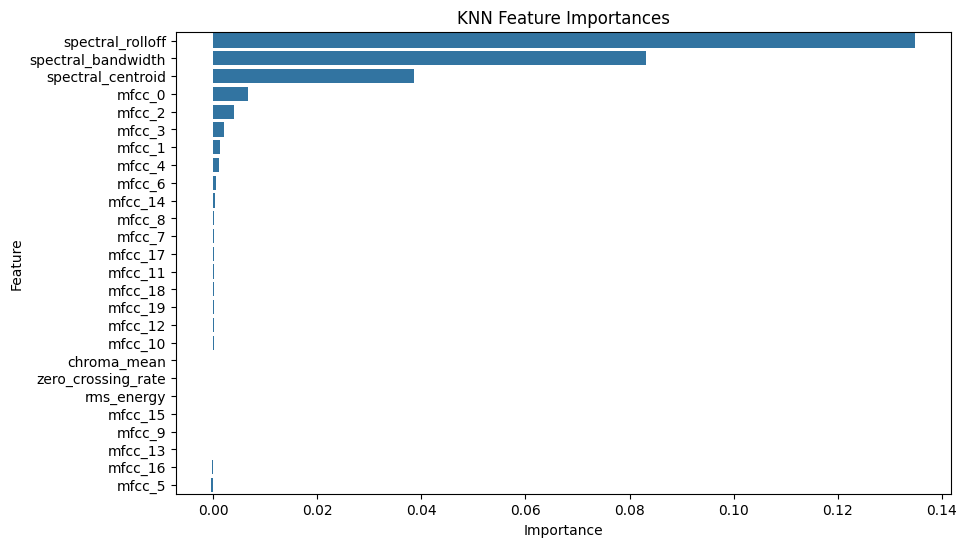


Random Forest Feature Importance:
               Feature  Importance
11             mfcc_11    0.095418
1               mfcc_1    0.084400
17             mfcc_17    0.083348
22  spectral_bandwidth    0.065978
8               mfcc_8    0.054685


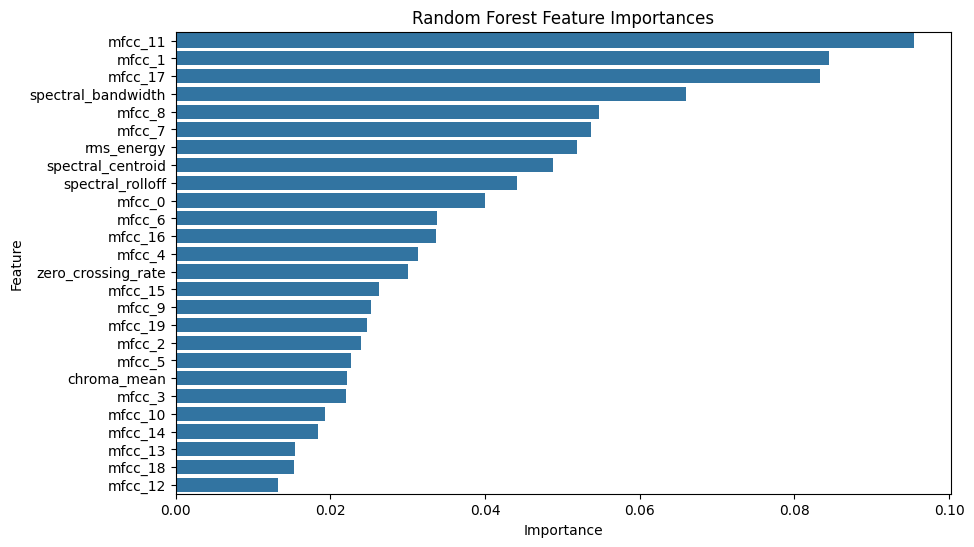


XGBoost Feature Importance:
       Feature  Importance
1       mfcc_1    0.156118
17     mfcc_17    0.127346
11     mfcc_11    0.067445
25  rms_energy    0.066044
8       mfcc_8    0.062347


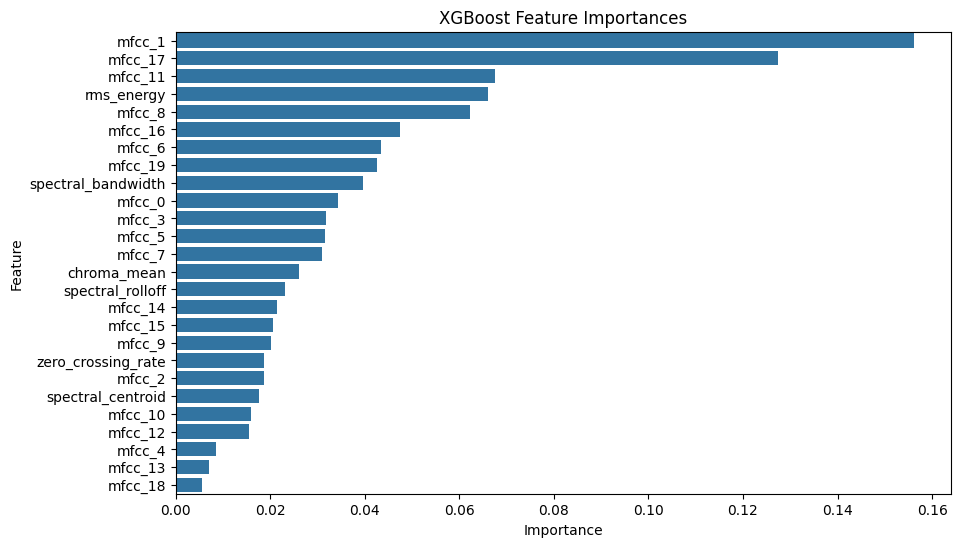


Saving the best model: XGBoost with AUC-ROC: 0.9996


In [ ]:
train_and_evaluate("/content/drive/MyDrive/KAGGLE/FAKE_audio_features_directory_3sec.csv",
                   "/content/drive/MyDrive/KAGGLE/REAL_audio_features_directory_3sec.csv", " ")


In [ ]:
import joblib
from sklearn import __version__

print("scikit-learn version:", __version__)


scikit-learn version: 1.5.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5470 - loss: 0.7076 - val_accuracy: 0.8352 - val_loss: 0.6395
Epoch 2/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5747 - loss: 0.6660 - val_accuracy: 0.8322 - val_loss: 0.6380
Epoch 3/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5839 - loss: 0.6624 - val_accuracy: 0.8670 - val_loss: 0.6197
Epoch 4/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5680 - loss: 0.6668 - val_accuracy: 0.8700 - val_loss: 0.6153
Epoch 5/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5801 - loss: 0.6606 - val_accuracy: 0.7634 - val_loss: 0.6333
Epoch 6/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5697 - loss: 0.6624 - val_accuracy: 0.8960 - val_loss: 0.5998
Epoch 7/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5735 - loss: 0.6546 - val_accuracy: 0.8599 - val_loss: 0.6204
Epoch 8/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5710 - loss: 0.6574 - val_accuracy: 0.

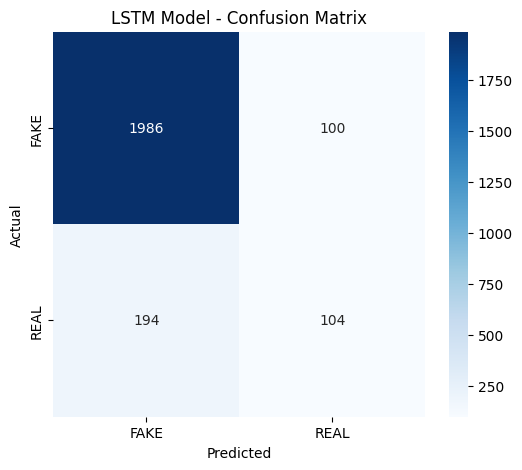

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load the datasets
fake_data = pd.read_csv('/content/drive/MyDrive/KAGGLE/FAKE_audio_features_directory_3sec.csv')
real_data = pd.read_csv('/content/drive/MyDrive/KAGGLE/REAL_audio_features_directory_3sec.csv')

# Combine the datasets
data = pd.concat([fake_data, real_data], ignore_index=True)

# Preprocessing
# Separate features and target
X = data.drop(columns=['type', 'file_name', 'interval_start', 'interval_end'])
y = data['type']

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 'FAKE' -> 0, 'REAL' -> 1

# Reshape for LSTM input (samples, timesteps, features)
X_lstm = np.expand_dims(X.values, axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for oversampling the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# Reshape the resampled data back for LSTM input
X_train_resampled = np.expand_dims(X_train_resampled, axis=1)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train_resampled)
y_test_cat = to_categorical(y_test)

# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_resampled, y_train_cat, epochs=20, batch_size=32, validation_data=(X_test, y_test_cat))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("LSTM Model - Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
train_and_evaluate("/content/drive/MyDrive/KAGGLE/FAKE_audio_features_directory_3sec.csv",
                   "/content/drive/MyDrive/KAGGLE/REAL_audio_features_directory_3sec.csv", " ")
